In [2]:
# Parameters
random_state = 42      # Default random_state
training_size = 0.125     # Default training_size
intensity = 0.25     # Default intensity

# Step 1: Load libraries

In [ ]:
# import libraries
import os
import re
import csv
import math
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import wasserstein_distance
import textwrap

# Set random seed
random_state = random_state
np.random.seed(random_state)

# model name
modelname = 'knn'

# training data size
training_size = training_size

noise_model = 'Gaussian'
# noise_model = 'Cats to Dogs'
# noise_model = 'Uniform'
intensity = intensity
heaviness = 0.5

%config InlineBackend.figure_formats = ['retina']

# Create a directory to save the results if it doesn't exist
output_dir = f'{modelname}_Results_{noise_model}_training_size_{training_size}_intensity_{intensity}_heaviness_{heaviness}_rs_{random_state}'
os.makedirs(output_dir, exist_ok=True)

# Step 2: Load union_feature dataset

In [4]:
# load the csv file
X = pd.read_csv('X_formation_energy_union_features.csv')
# remove the columns whose name is in X.select_dtypes(exclude=['number']).columns
X = X.drop(columns=X.select_dtypes(exclude=['number']).columns)

# Step 3: Train-Test-Validation Split

In [5]:
# train-val-test split = 80-10-10
df_train, df_test = train_test_split(X, test_size=0.2, random_state=random_state)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=random_state)

# Only keep part of the training data if training_size is less than 1.0
if training_size < 1.0:
    df_train, _ = train_test_split(df_train, test_size=1 - training_size, random_state=random_state)

df_train.shape, df_val.shape, df_test.shape

((7157, 46), (7157, 46), (7158, 46))

# Step 4: Feature Normalization

In [6]:
# nomralize the data using MinMaxScaler
scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=X.columns)
df_val = pd.DataFrame(scaler.transform(df_val), columns=X.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=X.columns)

# save df_test, df_val and df_train as a csv file
df_test.to_csv('df_test.csv', index=False)
df_val.to_csv('df_val.csv', index=False)
df_train.to_csv('df_train.csv', index=False)

# Step 5: Look at feature distributions
## Summary of Feature Distributions of test set

In [7]:
# Assuming df_test is your DataFrame with 46 features
num_features = df_test.shape[1]
n_cols = 6
n_rows = math.ceil(num_features / n_cols)  # Calculate number of rows needed

# Adjust the figure size as needed (here each subplot gets more space)
figsize = (n_cols * 4, n_rows * 3)

# Plot histograms with a layout that has exactly 6 subplots per row
axes = df_test.hist(bins=30, figsize=figsize, layout=(n_rows, n_cols))
plt.suptitle("Distribution of All Features", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the overall title
# save the figure to your output_dir
plt.savefig(f'{output_dir}/Distribution_of_all_features.png', dpi=300)
plt.close()

## Individual Feature Distributions of test set

In [ ]:
# 1) GLOBAL RC PARAMS (apply to all figures)
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"],
    "font.size": 8,              # base font size 8 pt
    "font.weight": "regular",
    "lines.linewidth": 1.0,      # min line width 1 pt
    "axes.linewidth": 1.0,
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.width": 1.0,
    "ytick.major.width": 1.0,
})

def wrap_to_two_lines(text, max_len=50):
    """Wrap long labels into two lines."""
    return "\n".join(textwrap.wrap(text, max_len))

def plot_individual_distributions(df, save_folder):
    """
    Plot overlaid histograms with KDE for each feature in df,
    styled per npj Computational Materials standards.
    """
    os.makedirs(save_folder, exist_ok=True)
    for feature in df.columns:
        fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
        
        # Histogram + KDE
        sns.histplot(
            df[feature].dropna(),
            bins=30,
            kde=True,
            color='blue',
            alpha=0.7,
            edgecolor='black',
            ax=ax
        )
        
        # Axis labels (8 pt bold)
        ax.set_xlabel(wrap_to_two_lines(feature), fontsize=8)
        ax.set_ylabel("Frequency", fontsize=8)
        
        # Tick label size
        ax.tick_params(axis='both', labelsize=8)
        
        # Optional panel label, e.g., "(f)"
        ax.text(-0.1, 1.05, "(d)", transform=ax.transAxes,
                fontsize=12, fontweight='bold')
        
        fig.tight_layout()
        
        # Sanitize filename
        safe_name = re.sub(r'[^\w\-_\. ]', '_', feature).replace(" ", "_")
        filepath = os.path.join(save_folder, f"{safe_name}.png")
        fig.savefig(filepath, dpi=300, facecolor='white', bbox_inches='tight')
        plt.close(fig)

# Example usage:
plot_individual_distributions(df_test, os.path.join(output_dir, "individual_feature_distribution_plots"))


# Step 6: Baseline Model training on validation set

## KNN model hyperparameter  Setup

In [ ]:
# Hyperparameter got from step_2
if modelname == 'knn':
    model = KNeighborsRegressor(
        n_neighbors=5,
        weights='distance',
        algorithm='kd_tree',
        leaf_size=30,
        p=1,
        n_jobs=-1,
        )

## Baseline model evaluations

In [ ]:
y_val_preds = []
y_test_preds = []
results = []

for target_col in X.columns:

    X_train, y_train = df_train.drop(columns=[target_col]), df_train[target_col]
    X_val, y_val = df_val.drop(columns=[target_col]), df_val[target_col]
    X_test, y_test = df_test.drop(columns=[target_col]), df_test[target_col]

    model.fit(X_train, y_train)
    y_val_pred = pd.Series(model.predict(X_val), index=y_val.index, name=target_col)
    y_test_pred = pd.Series(model.predict(X_test), index=y_test.index, name=target_col)

    y_val_preds.append(y_val_pred)
    y_test_preds.append(y_test_pred)

    val_r2 = r2_score(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    # Store the results in a list of dictionaries
    results.append({
        'target_col': target_col,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'test_r2': test_r2,
        'test_mae': test_mae
    })

# After the loop, create a DataFrame and save it to a CSV file in out_dir
results_df = pd.DataFrame(results)
results_file = os.path.join(output_dir, 'baseline_evaluation_results.csv')
results_df.to_csv(results_file, index=False)

# save the results
df_val_pred = pd.concat(y_val_preds, axis=1)
df_test_pred = pd.concat(y_test_preds, axis=1)

# Save the predictions
df_val_pred.to_csv(f'{output_dir}/df_val_pred.csv', index=False)
df_test_pred.to_csv(f'{output_dir}/df_test_pred.csv', index=False)

## Calculate the difference between the correction and ground truth, delta_base

In [10]:
delta_base = df_val_diff = abs(df_val_pred - df_val)
# save the results
delta_base.to_csv(os.path.join(output_dir, 'delta_base.csv'), index=False)

## Plot the delta base for all features

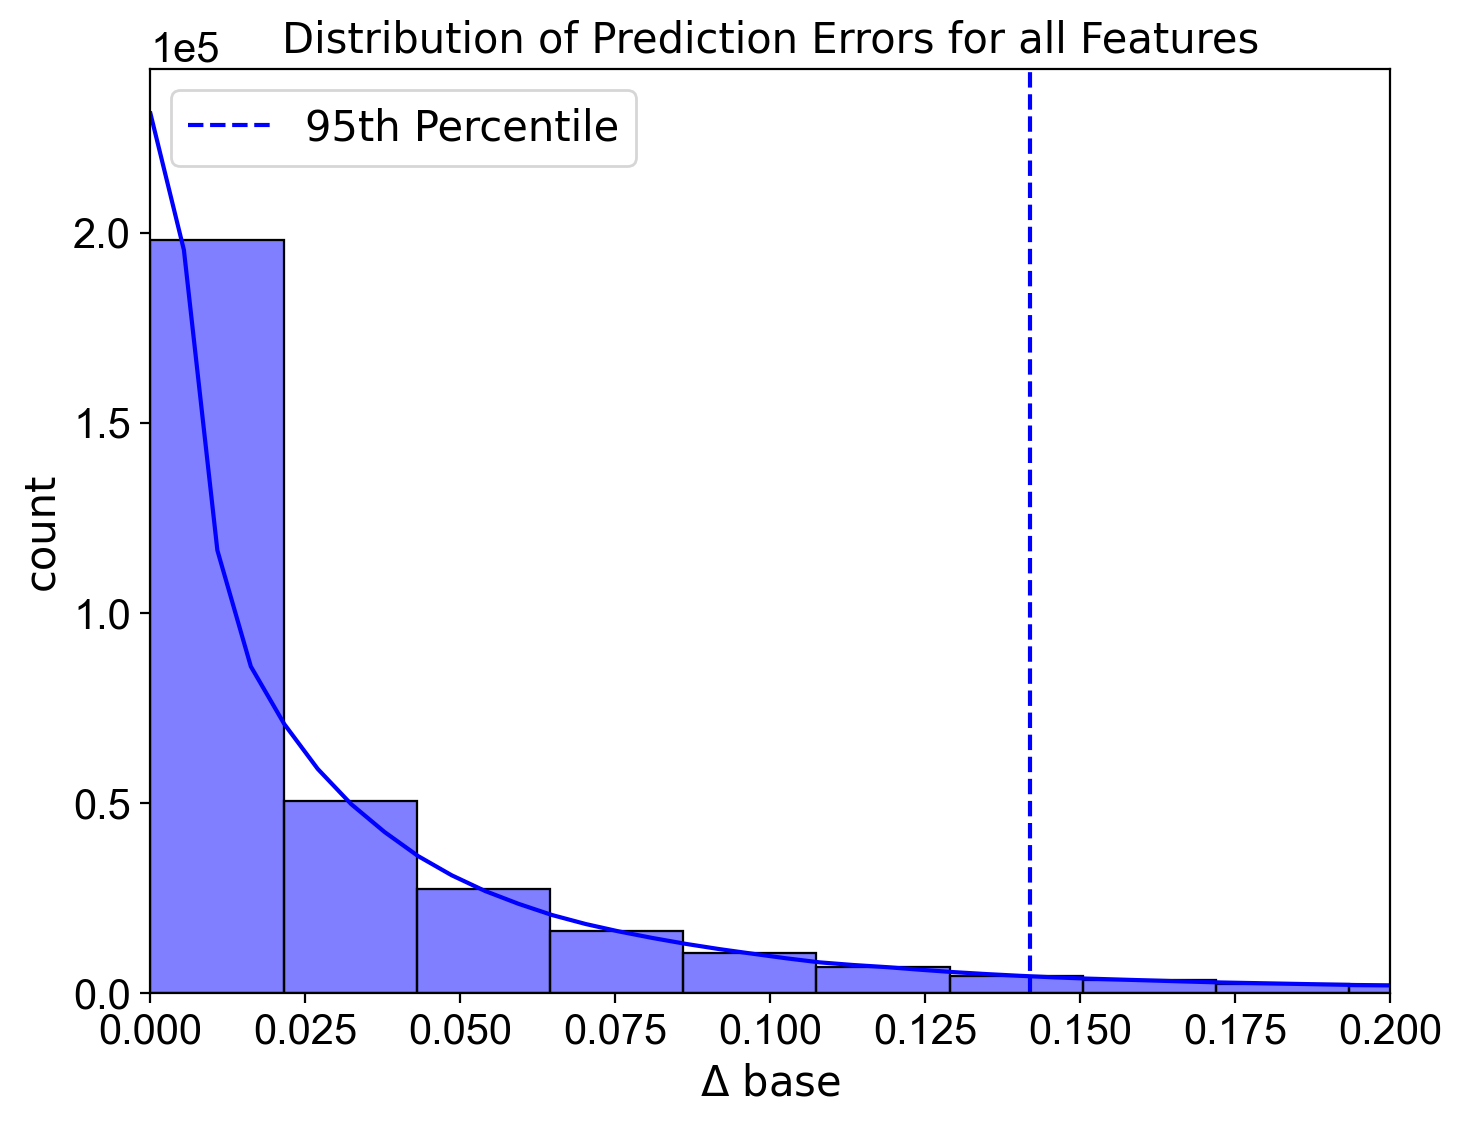

In [ ]:
plt.figure(figsize=(8, 6))

# Plot the histogram with KDE in blue
sns.histplot(delta_base.values.flatten(), bins=50, kde=True, color='blue')

# Update title and labels with increased font size, bold styling, and blue color
plt.title('Distribution of Prediction Errors for all Features', fontsize=15)
plt.xlabel(r'$\Delta$ base', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.xlim(0, 0.2)

# Set font size and font family for tick labels
plt.xticks(fontsize=15, fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')

# Format y-axis tick labels in scientific (exponential) notation
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# Change the offset text (e.g., "e10") font to match other labels
ax = plt.gca()
offset_text = ax.yaxis.get_offset_text()
offset_text.set_fontsize(15)
offset_text.set_fontname('Arial')

# Calculate and plot the 95th percentile line in blue
val_error_95th_percentile = np.percentile(delta_base.values.flatten(), 95)
plt.axvline(val_error_95th_percentile, color='blue', linestyle='--', label='95th Percentile')

# Add legend with updated font sizes
plt.legend(fontsize=15, title_fontsize=15)

# Save and display the plot
plt.savefig(os.path.join(output_dir, 'val_error_distribution.png'), dpi=300, bbox_inches='tight')
plt.close()


## Plots of delta base for individual features

In [ ]:
for col in delta_base.columns:
    plt.figure(figsize=(8, 6))
    
    # Plot the histogram with KDE in blue for the current feature
    sns.histplot(delta_base[col], bins=50, kde=True, color='blue')
    
    # Update title and labels with the specified font size and style
    plt.title(f'Distribution of Prediction Errors for {col}', fontsize=15)
    plt.xlabel(r'$\Delta$ base', fontsize=15)
    plt.ylabel('count', fontsize=15)
    plt.xlim(0, 0.2)
    
    # Set tick labels with Arial font and desired font size
    plt.xticks(fontsize=15, fontname='Arial')
    plt.yticks(fontsize=15, fontname='Arial')
    
    # Format y-axis tick labels in scientific notation
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    
    # Update the offset text (e.g., "e10") to match the tick label style
    ax = plt.gca()
    offset_text = ax.yaxis.get_offset_text()
    offset_text.set_fontsize(15)
    offset_text.set_fontname('Arial')
    
    # Calculate and plot the 95th percentile line in blue
    val_error_95th_percentile = np.percentile(delta_base[col], 95)
    plt.axvline(val_error_95th_percentile, color='blue', linestyle='--', label='95th Percentile')
    
    # Add legend with updated font sizes
    plt.legend(fontsize=15, title_fontsize=15)
    
    # Save and display the plot for the current feature
    plt.savefig(os.path.join(output_dir, f'val_error_distribution_{col}.png'),
                dpi=300, bbox_inches='tight')
    plt.close()

# Step 7: Introduce noise to the test set

In [13]:
def introduce_noise(X_test, noise_model='Gaussian', intensity=0.125, heaviness=0.5):
    # Check if X_test is a DataFrame and extract column names
    if isinstance(X_test, pd.DataFrame):
        feature_names = X_test.columns
    else:
        feature_names = [f"Feature_{i+1}" for i in range(X_test.shape[1])]
    
    X_test = np.array(X_test)
    n_samples, n_features = X_test.shape
    
    # Initialize noise array
    noise = np.zeros_like(X_test)
    
    # Noise model implementation
    if noise_model == 'Gaussian':
        noise = np.random.normal(loc=0, scale=intensity, size=(n_samples, n_features)) 
        X_test_noise = noise + X_test
        
    elif noise_model == 'Poisson':
        lam = np.abs(X_test) * intensity
        noise = np.random.poisson(lam=lam)
        X_test_noise = noise + X_test
        
    elif noise_model == 'T-student':
        noise = stats.t.rvs(df=heaviness, size=(n_samples, n_features)) * intensity
        X_test_noise = noise + X_test
    
    elif noise_model == 'Salt and Pepper':
        # Convert values less than 0.5 to 1, and values >= 0.5 to 0
        noise = np.where(X_test < 0.5, 1, 0)
        X_test_noise = noise

    elif noise_model == 'Uniform':
        noise = np.random.uniform(low=0, high=1, size=(n_samples, n_features))
        X_test_noise = noise

    elif noise_model == 'constant':
        noise = X_test * intensity
        X_test_noise = noise
        
    else:
        raise ValueError(f"Unsupported noise model: {noise_model}") 

    # after introduce noies to the test set, we need to make sure the values are still within the range [0, 1]
    X_test_noise = np.clip(X_test_noise, 0, 1)
    
    # Create a DataFrame with the noisy features
    df_noise = pd.DataFrame(noise, columns=feature_names)
    df_test_noise = pd.DataFrame(X_test_noise, columns=feature_names)
    
    return df_noise, df_test_noise

In [14]:
df_noise, df_test_noise = introduce_noise(df_test, noise_model=noise_model, intensity=intensity, heaviness=heaviness)

# Save df_noise and df_test_noise to CSV
df_noise.to_csv(os.path.join(output_dir, 'df_noise.csv'), index=False)
df_test_noise.to_csv(os.path.join(output_dir, 'df_test_noise.csv'), index=False)

## check feature distributions before and after introducing noise

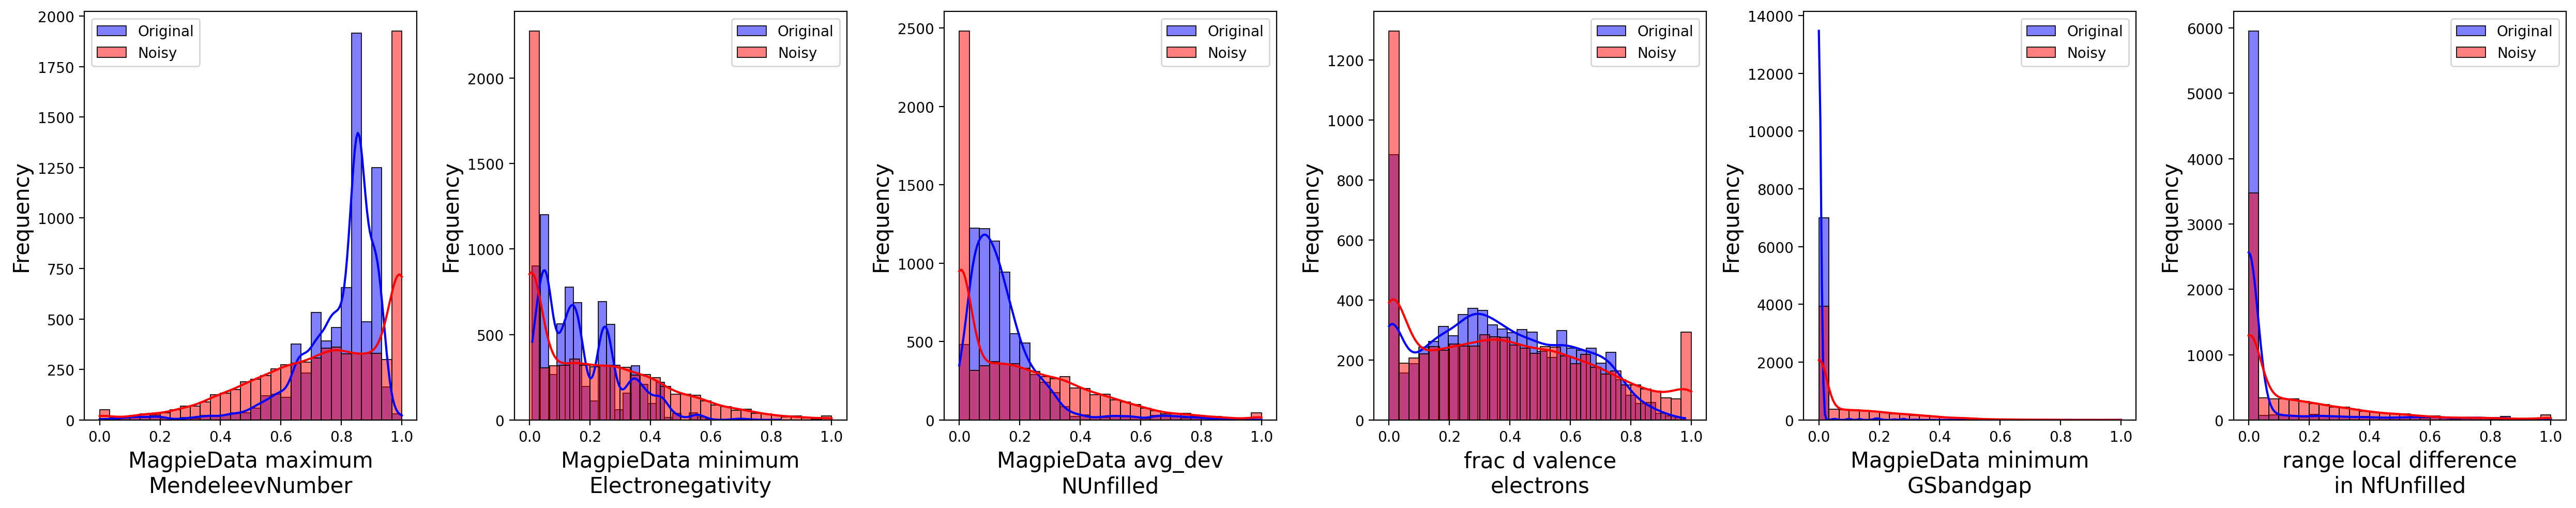

In [15]:
# List the six features you want to examine
features = [
    'MagpieData maximum MendeleevNumber', 
    'MagpieData minimum Electronegativity', 
    'MagpieData avg_dev NUnfilled', 
    'frac d valence electrons', 
    'MagpieData minimum GSbandgap', 
    'range local difference in NfUnfilled'
]

# Create a figure and a grid of subplots (1 row, 6 columns)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(25, 5))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Loop over each feature and its corresponding subplot axis
for ax, feature in zip(axes, features):
    # Plot the original data distribution in blue
    sns.histplot(df_test[feature], bins=30, kde=True, color='blue', alpha=0.5, label='Original', ax=ax)
    # Plot the noisy data distribution in red
    sns.histplot(df_test_noise[feature], bins=30, kde=True, color='red', alpha=0.5, label='Noisy', ax=ax)
    
    # Wrap the feature name for better display on the x-axis
    wrapped_title = textwrap.fill(feature, width=22)
    ax.set_xlabel(wrapped_title, fontsize=15)
    ax.set_ylabel("Frequency", fontsize=15)
    
    # Add legend to distinguish between the two distributions
    ax.legend()

plt.tight_layout()

# save the figure
plt.savefig(f'{output_dir}/clean_and_noisy_feature_distribution.png', dpi=300)
plt.show()

## calculate the difference of noisy test data and recoveried test data

In [ ]:
delta_noise = abs(df_test_pred - df_test_noise)
# Save delta_noise to CSV
delta_noise.to_csv(os.path.join(output_dir, 'delta_noise.csv'), index=False)

# Step 8: Noisy feature detection

In [17]:
# Initialize a dictionary to store all results
results = {}

# Adding tqdm progress bar to the outer loop
for noise_col in tqdm(X.columns, desc='Processing noise columns'):
    # Replace one feature in the test set with the noisy feature
    df_test_updated = df_test.copy()
    df_test_updated[noise_col] = df_test_noise[noise_col]

    # Initialize nested dictionaries to store results for this noise_col
    results[noise_col] = {
        'y_test_preds': {},
        'y_test_diffs': {},
        'model_eval_results': []
    }

    # Adding tqdm progress bar to the inner loop for target columns
    for target_col in tqdm(X.columns, desc=f'Processing target columns for {noise_col}', leave=False):
        # Prepare training and test sets
        X_train = df_train.drop(columns=[target_col])
        y_train = df_train[target_col]
        X_test = df_test_updated.drop(columns=[target_col])
        y_test = df_test_updated[target_col]

        # Fit the model
        model.fit(X_train, y_train)
        y_test_pred = pd.Series(model.predict(X_test), index=y_test.index, name=target_col)

        # Store predictions
        results[noise_col]['y_test_preds'][target_col] = y_test_pred

        # Calculate the absolute difference between predicted and actual values
        y_test_diff = abs(y_test_pred - y_test)
        results[noise_col]['y_test_diffs'][target_col] = y_test_diff

        # Calculate evaluation metrics
        r2 = r2_score(y_test, y_test_pred)
        mae = mean_absolute_error(y_test, y_test_pred)

        # Store evaluation results
        results[noise_col]['model_eval_results'].append({
            'target_col': target_col,
            'r2': r2,
            'mae': mae
        })

# Define the full file path
save_path = os.path.join(output_dir, 'noisy_feature_impact_results.pkl')

# Save the results to the specified path
with open(save_path, 'wb') as f:
    pickle.dump(results, f)

print(f"File saved to: {os.path.abspath(save_path)}")

Processing noise columns: 100%|██████████| 46/46 [19:24<00:00, 25.31s/it]

File saved to: /Users/sara/Documents/code/noise_papers/knn_Results_Gaussian_training_size_0.125_intensity_0.25_heaviness_0.5_rs_42/noisy_feature_impact_results.pkl


In [40]:
# Specify the filename of your pickle file
pickle_filename = 'noisy_feature_impact_results.pkl'  # Replace with your actual filename

# Combine the directory path with the filename
file_path = os.path.join(output_dir, pickle_filename)

# Load the pickle file
with open(file_path, 'rb') as f:
    results = pickle.load(f)

In [41]:
# Initialize a counter for the number of times the noisy feature is the one with the largest EMD
count_noisy_feature_max_emd = 0

# List to keep track of features
feature_list = delta_base.columns.tolist()

# Define compute_emd function (ensure it's accessible)
def compute_emd(delta_base, delta_noise, columns):
    emd_values = {}
    for feature in columns:
        # Extract the values for the current feature
        base_values = delta_base[feature].dropna()
        noise_values = delta_noise[feature].dropna()
        
        # Compute the Earth Mover's Distance
        emd = wasserstein_distance(base_values, noise_values)
        emd_values[feature] = emd
    return emd_values

# Loop over all features in delta_base
for noisy_feature in feature_list:
    print(f"Processing noisy feature: {noisy_feature}")
    
    # Check if the key exists in the results dictionary
    if noisy_feature in results and 'y_test_diffs' in results[noisy_feature]:
        delta_noise = pd.DataFrame(results[noisy_feature]["y_test_diffs"])
    else:
        print(f"No data found for noisy feature: {noisy_feature}. Skipping.")
        continue  # Skip to the next feature

    # Convert column names to strings for consistency
    delta_base.columns = delta_base.columns.map(str)
    delta_noise.columns = delta_noise.columns.map(str)

    # Identify common columns between delta_base and delta_noise
    common_columns = delta_base.columns.intersection(delta_noise.columns).tolist()

    # If no common columns, skip this feature
    if not common_columns:
        print(f"No common columns found for feature: {noisy_feature}. Skipping.")
        continue

    # Compute EMD values for all common features
    all_columns = common_columns
    emd_values_all = compute_emd(delta_base, delta_noise, all_columns)
    
    # Find the maximum EMD value
    max_emd_value = max(emd_values_all.values())
    
    # Find all features that have the maximum EMD value
    max_emd_features = [feature for feature, emd in emd_values_all.items() if emd == max_emd_value]
    
    # Check if the noisy feature is among the features with the largest EMD
    if noisy_feature in max_emd_features:
        count_noisy_feature_max_emd += 1
        print(f"The noisy feature '{noisy_feature}' is among the features with the largest EMD.")
    else:
        print(f"The noisy feature '{noisy_feature}' is NOT among the features with the largest EMD.")
        
# After looping through all features
total_features = len(feature_list)
success_rate = (count_noisy_feature_max_emd / total_features) * 100
# print(f"\nOut of {total_features} features, the noisy feature was the feature with the largest EMD {count_noisy_feature_max_emd} times.")
# print(f"This is {success_rate:.2f}% of the time.")

# **Save the success rate into a CSV file with additional information**
csv_file_path = os.path.join(output_dir, 'success_rates.csv')

# Prepare the data to be written
data_row = {
    'training_size': training_size,
    'noise_type': noise_model,
    'noise_intensity': intensity,
    'success_rate': success_rate
}

# Check if the CSV file exists
file_exists = os.path.isfile(csv_file_path)

# Write to the CSV file
with open(csv_file_path, 'a', newline='') as csvfile:
    fieldnames = ['training_size', 'noise_type', 'noise_intensity', 'success_rate']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # If the file doesn't exist, write the header
    if not file_exists:
        writer.writeheader()
    
    # Write the data row
    writer.writerow(data_row)

print(f"Success rate saved to {csv_file_path}")

Processing noisy feature: mean neighbor distance variation
The noisy feature 'mean neighbor distance variation' is among the features with the largest EMD.
Processing noisy feature: MagpieData mode NsValence
The noisy feature 'MagpieData mode NsValence' is among the features with the largest EMD.
Processing noisy feature: MagpieData maximum SpaceGroupNumber
The noisy feature 'MagpieData maximum SpaceGroupNumber' is among the features with the largest EMD.
Processing noisy feature: MagpieData maximum MendeleevNumber
The noisy feature 'MagpieData maximum MendeleevNumber' is among the features with the largest EMD.
Processing noisy feature: avg_dev local difference in CovalentRadius
The noisy feature 'avg_dev local difference in CovalentRadius' is among the features with the largest EMD.
Processing noisy feature: MagpieData range NdValence
The noisy feature 'MagpieData range NdValence' is among the features with the largest EMD.
Processing noisy feature: MagpieData mean Column
The noisy f

## If want to check one specific noisy feature in details, the following code can be used

/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/3722296884.py:59: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


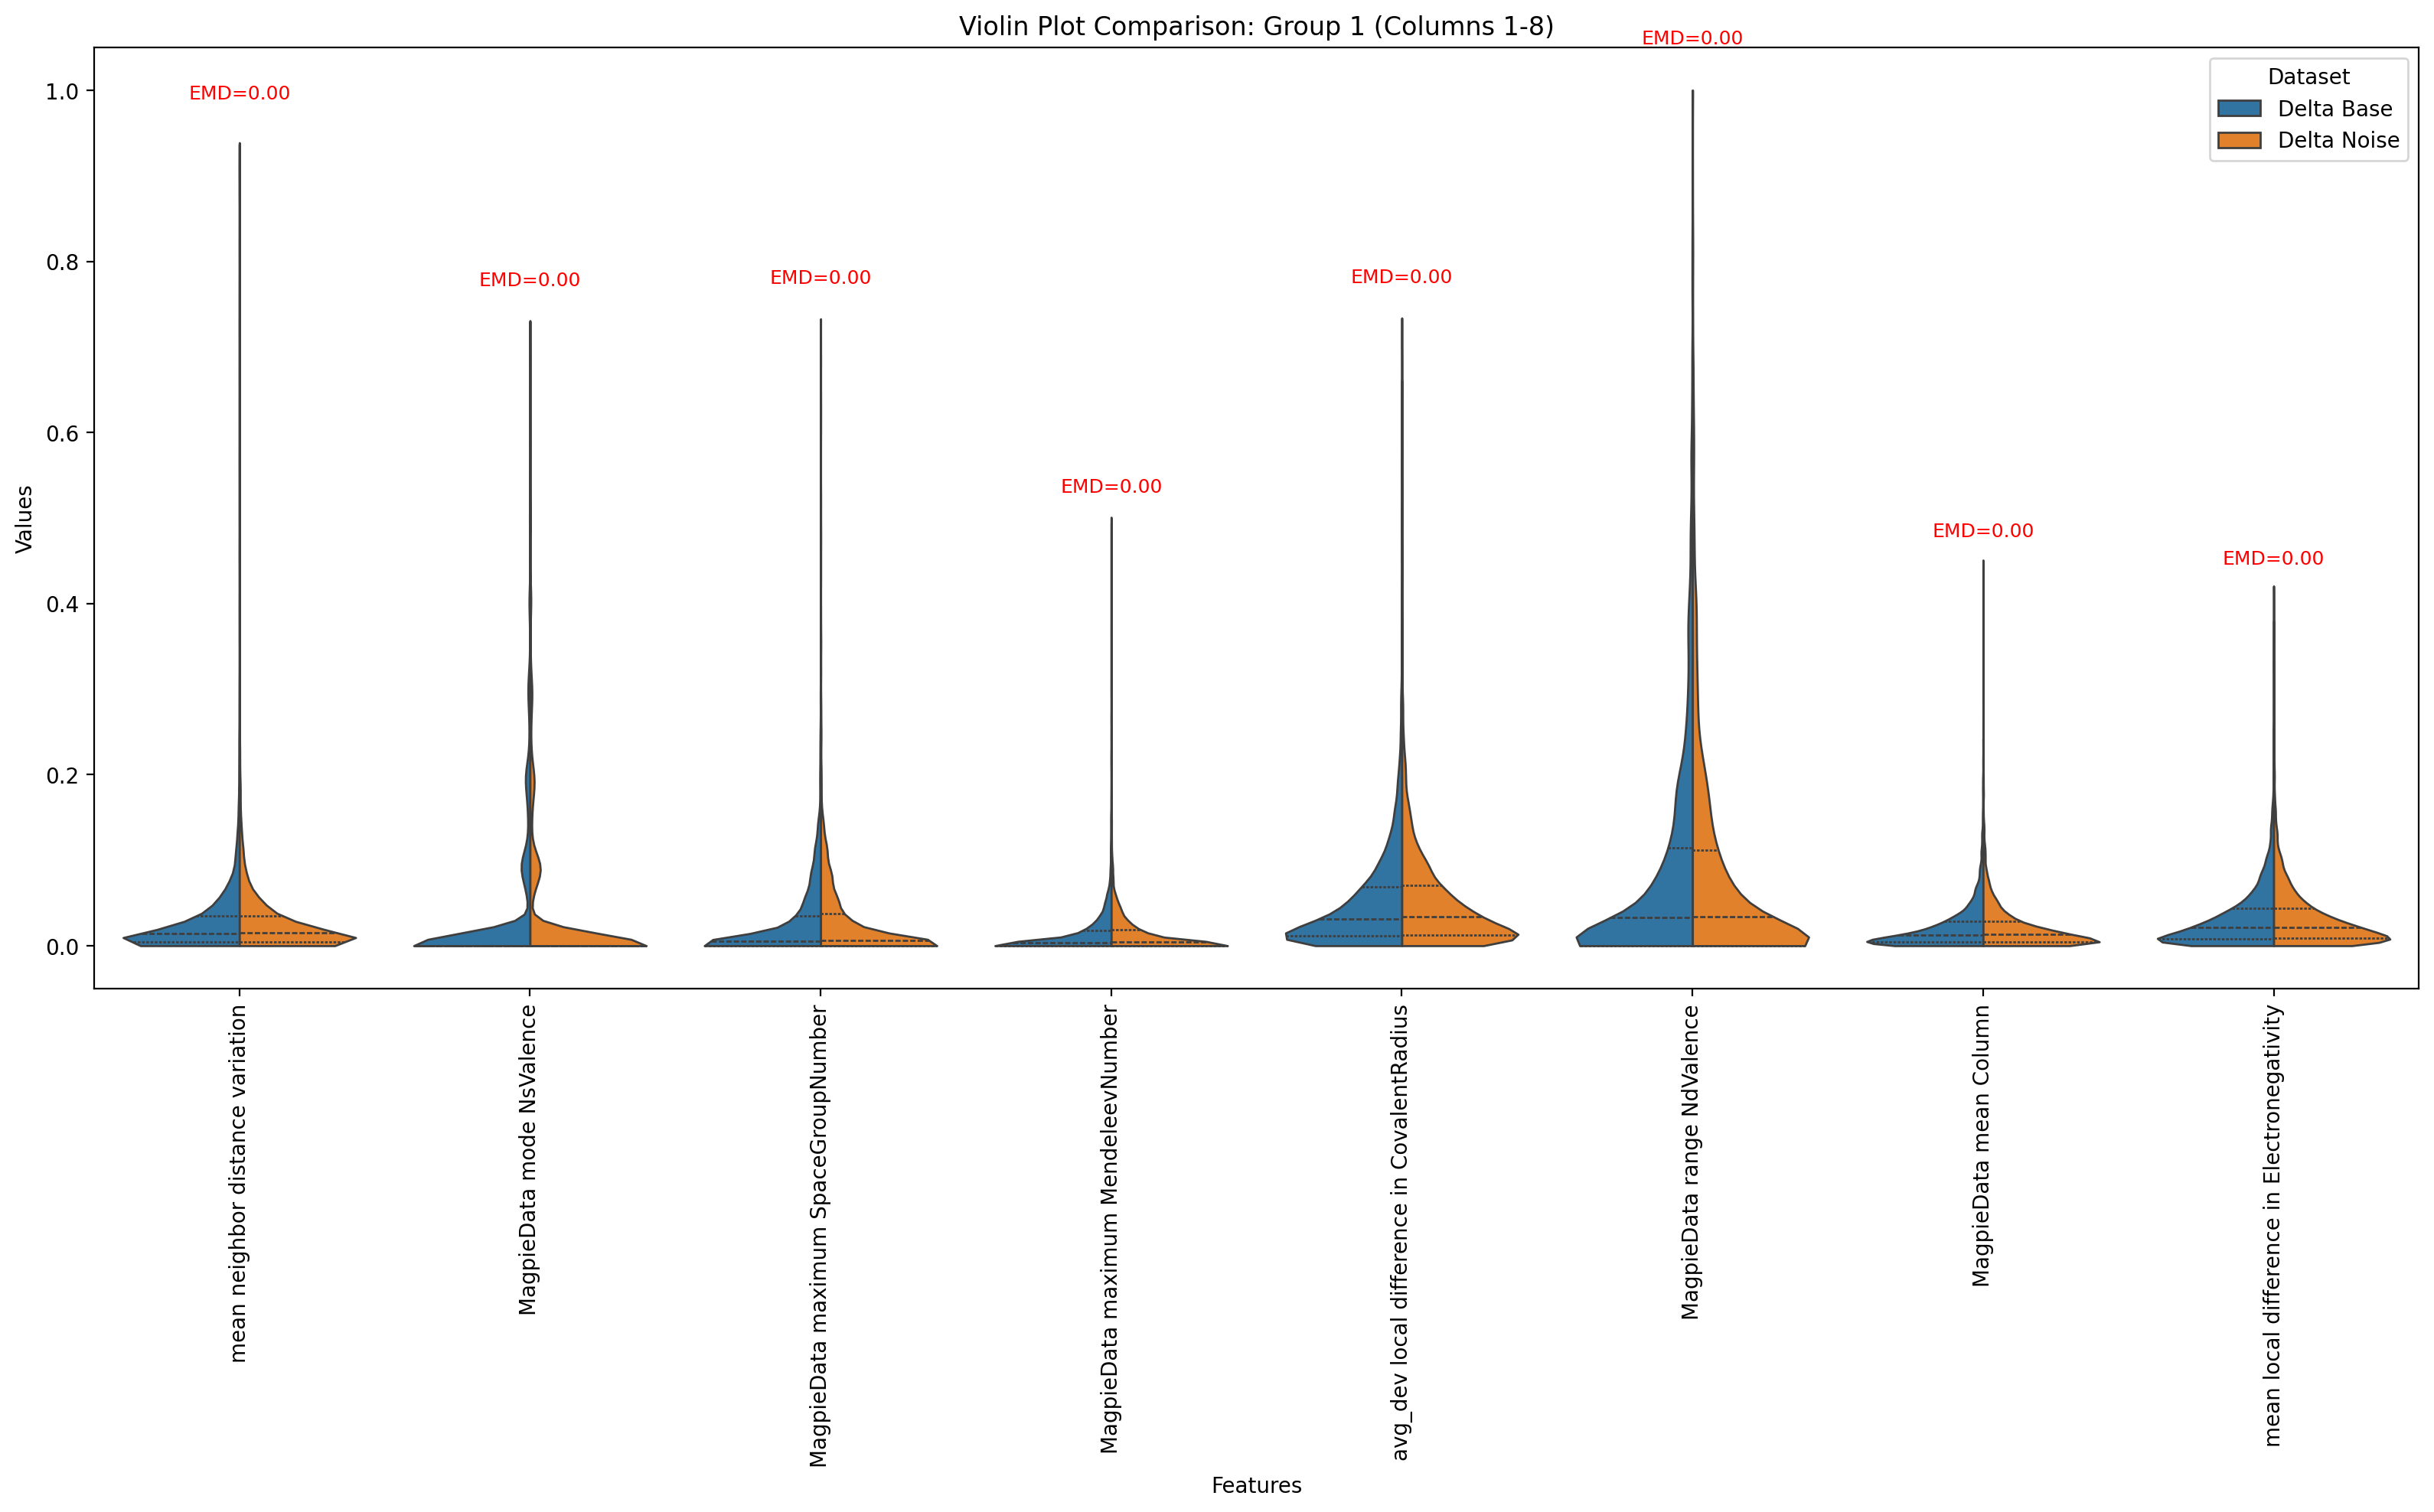

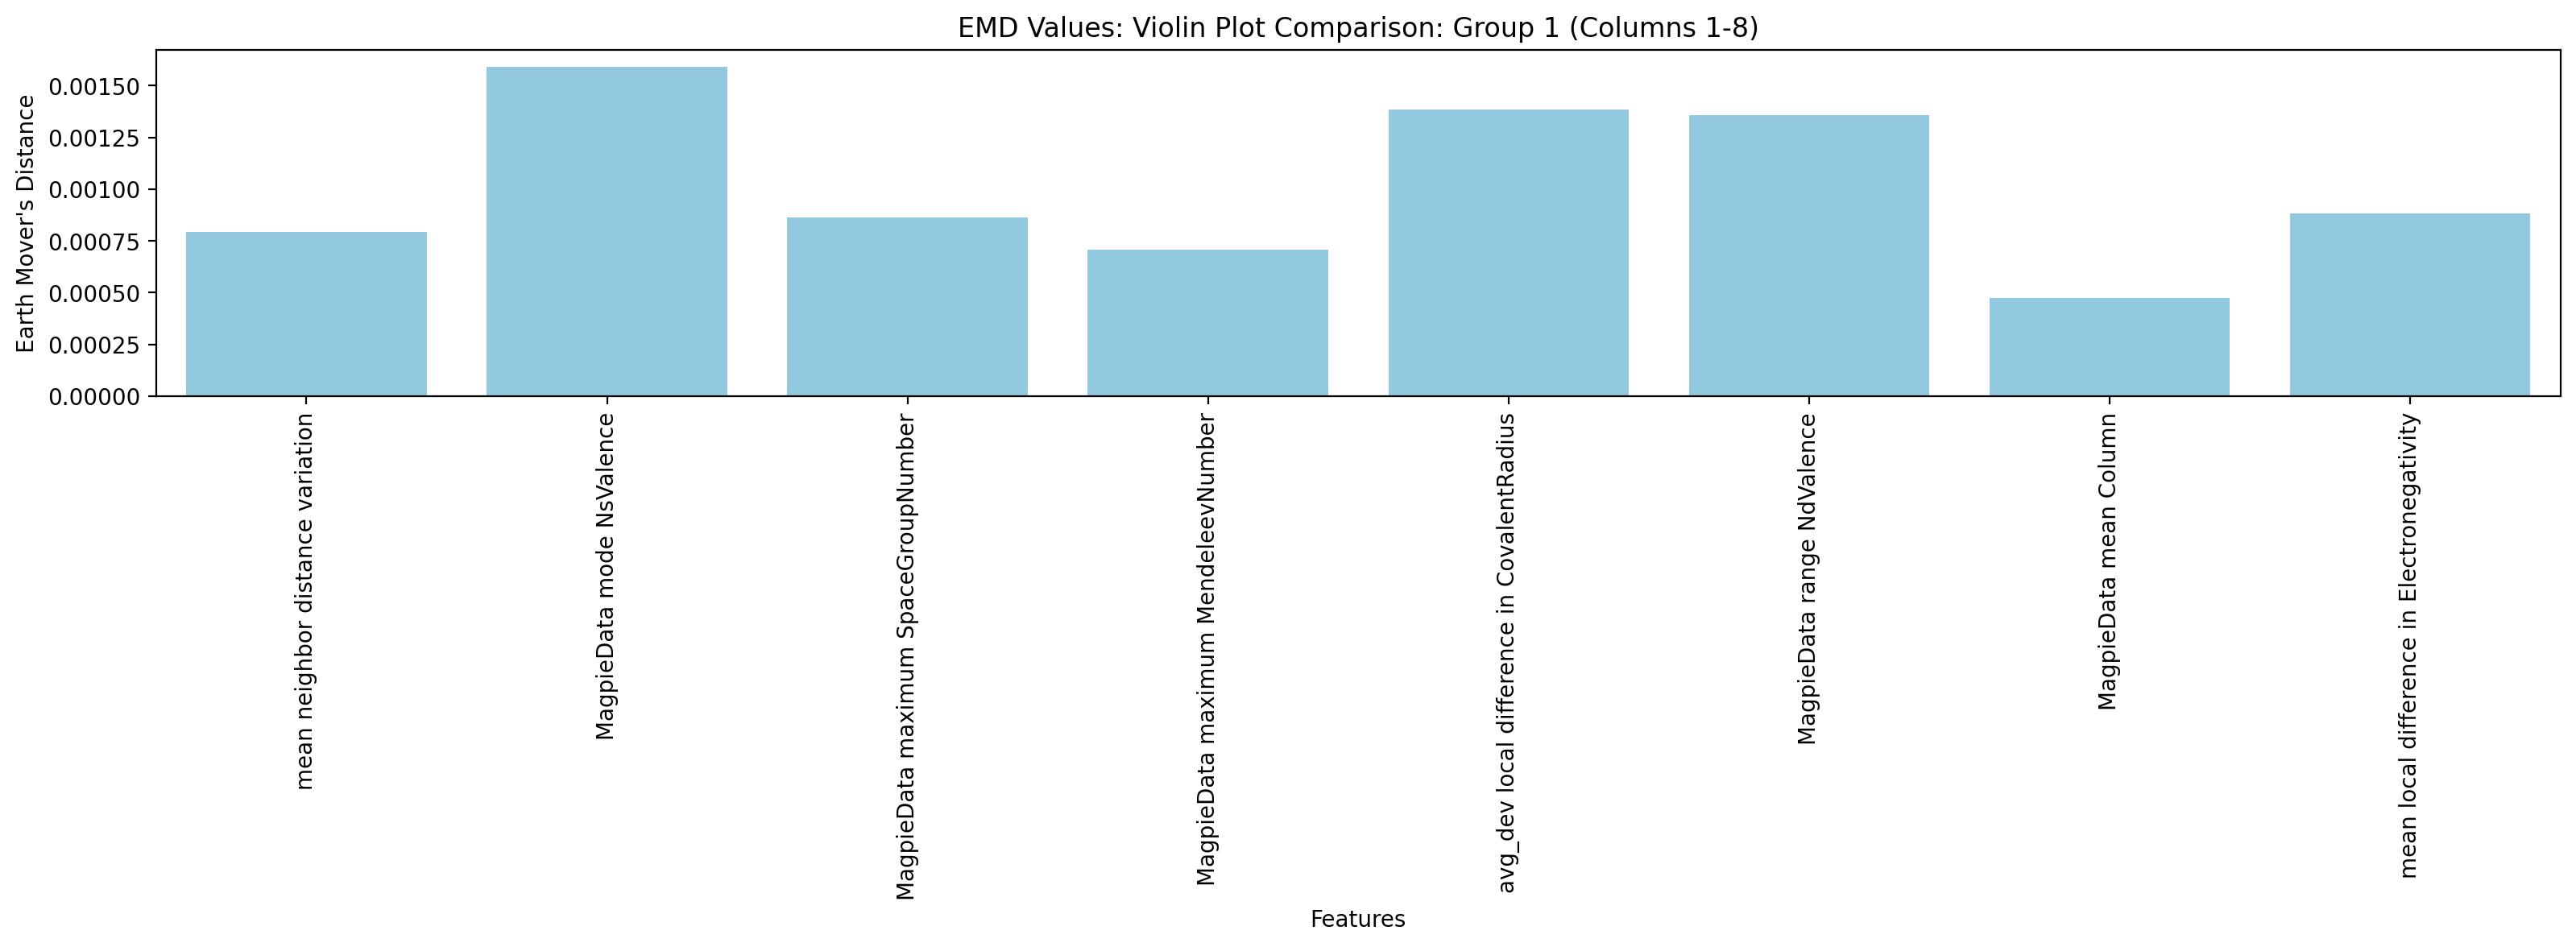

/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/3722296884.py:59: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


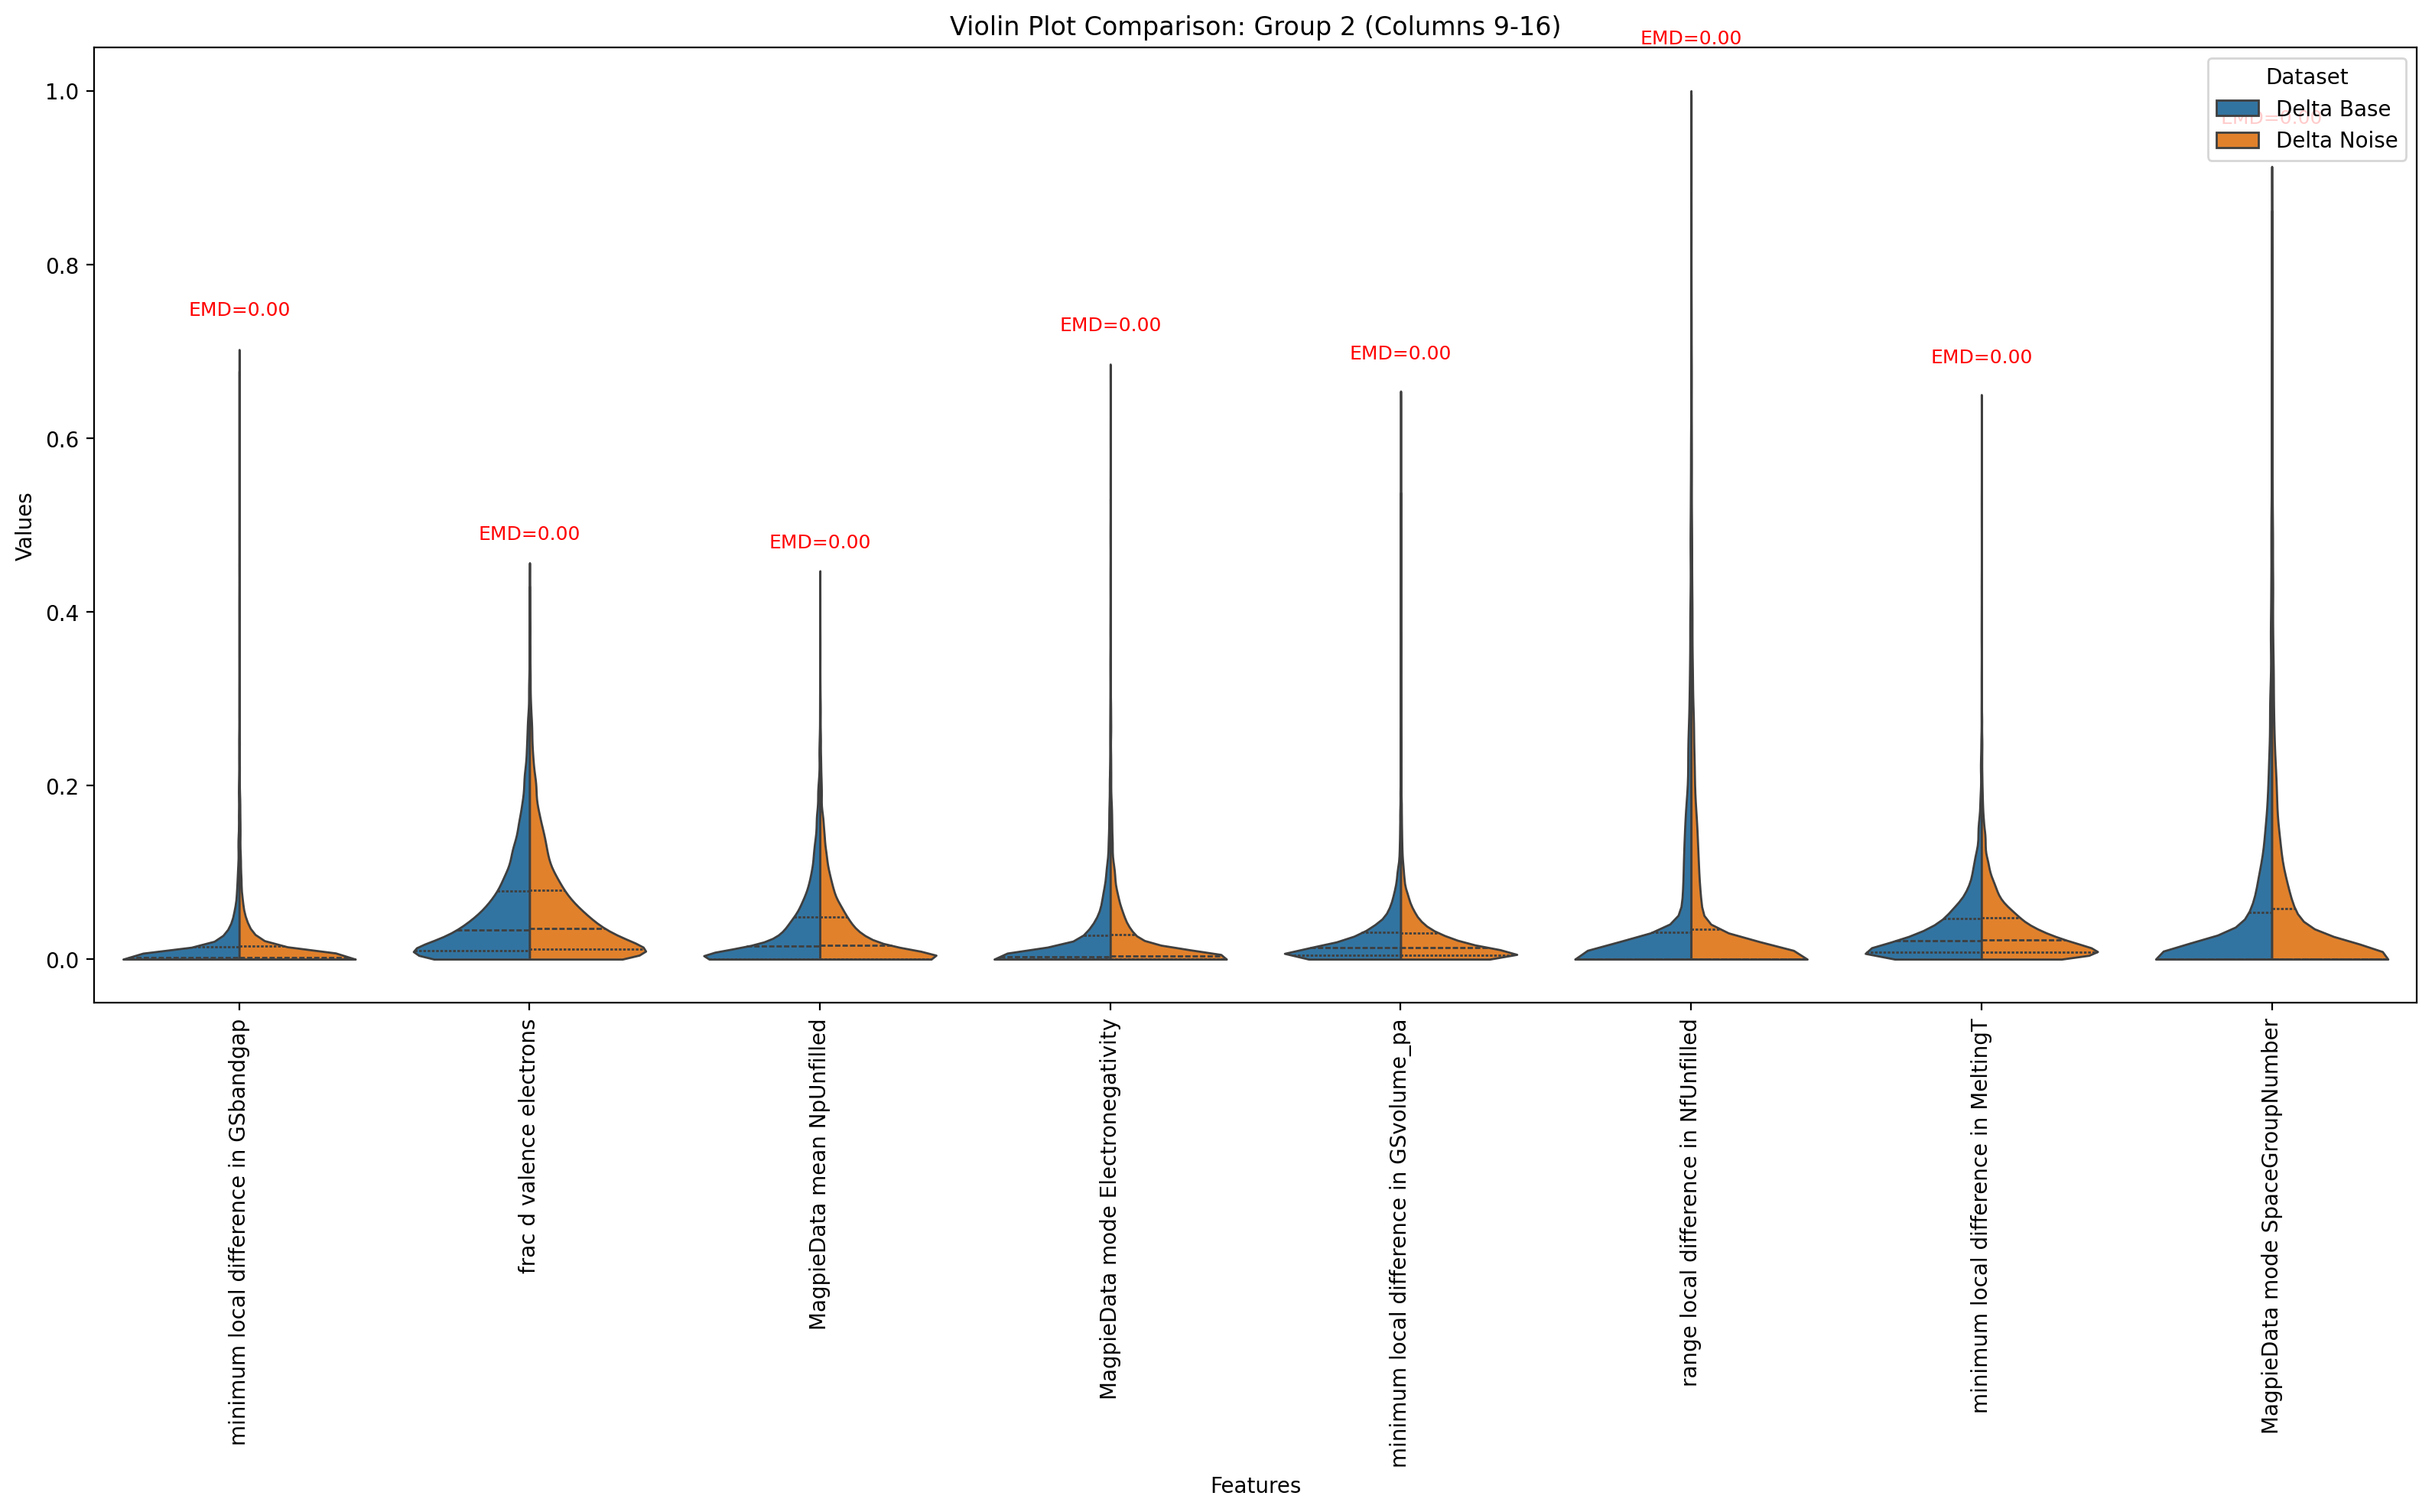

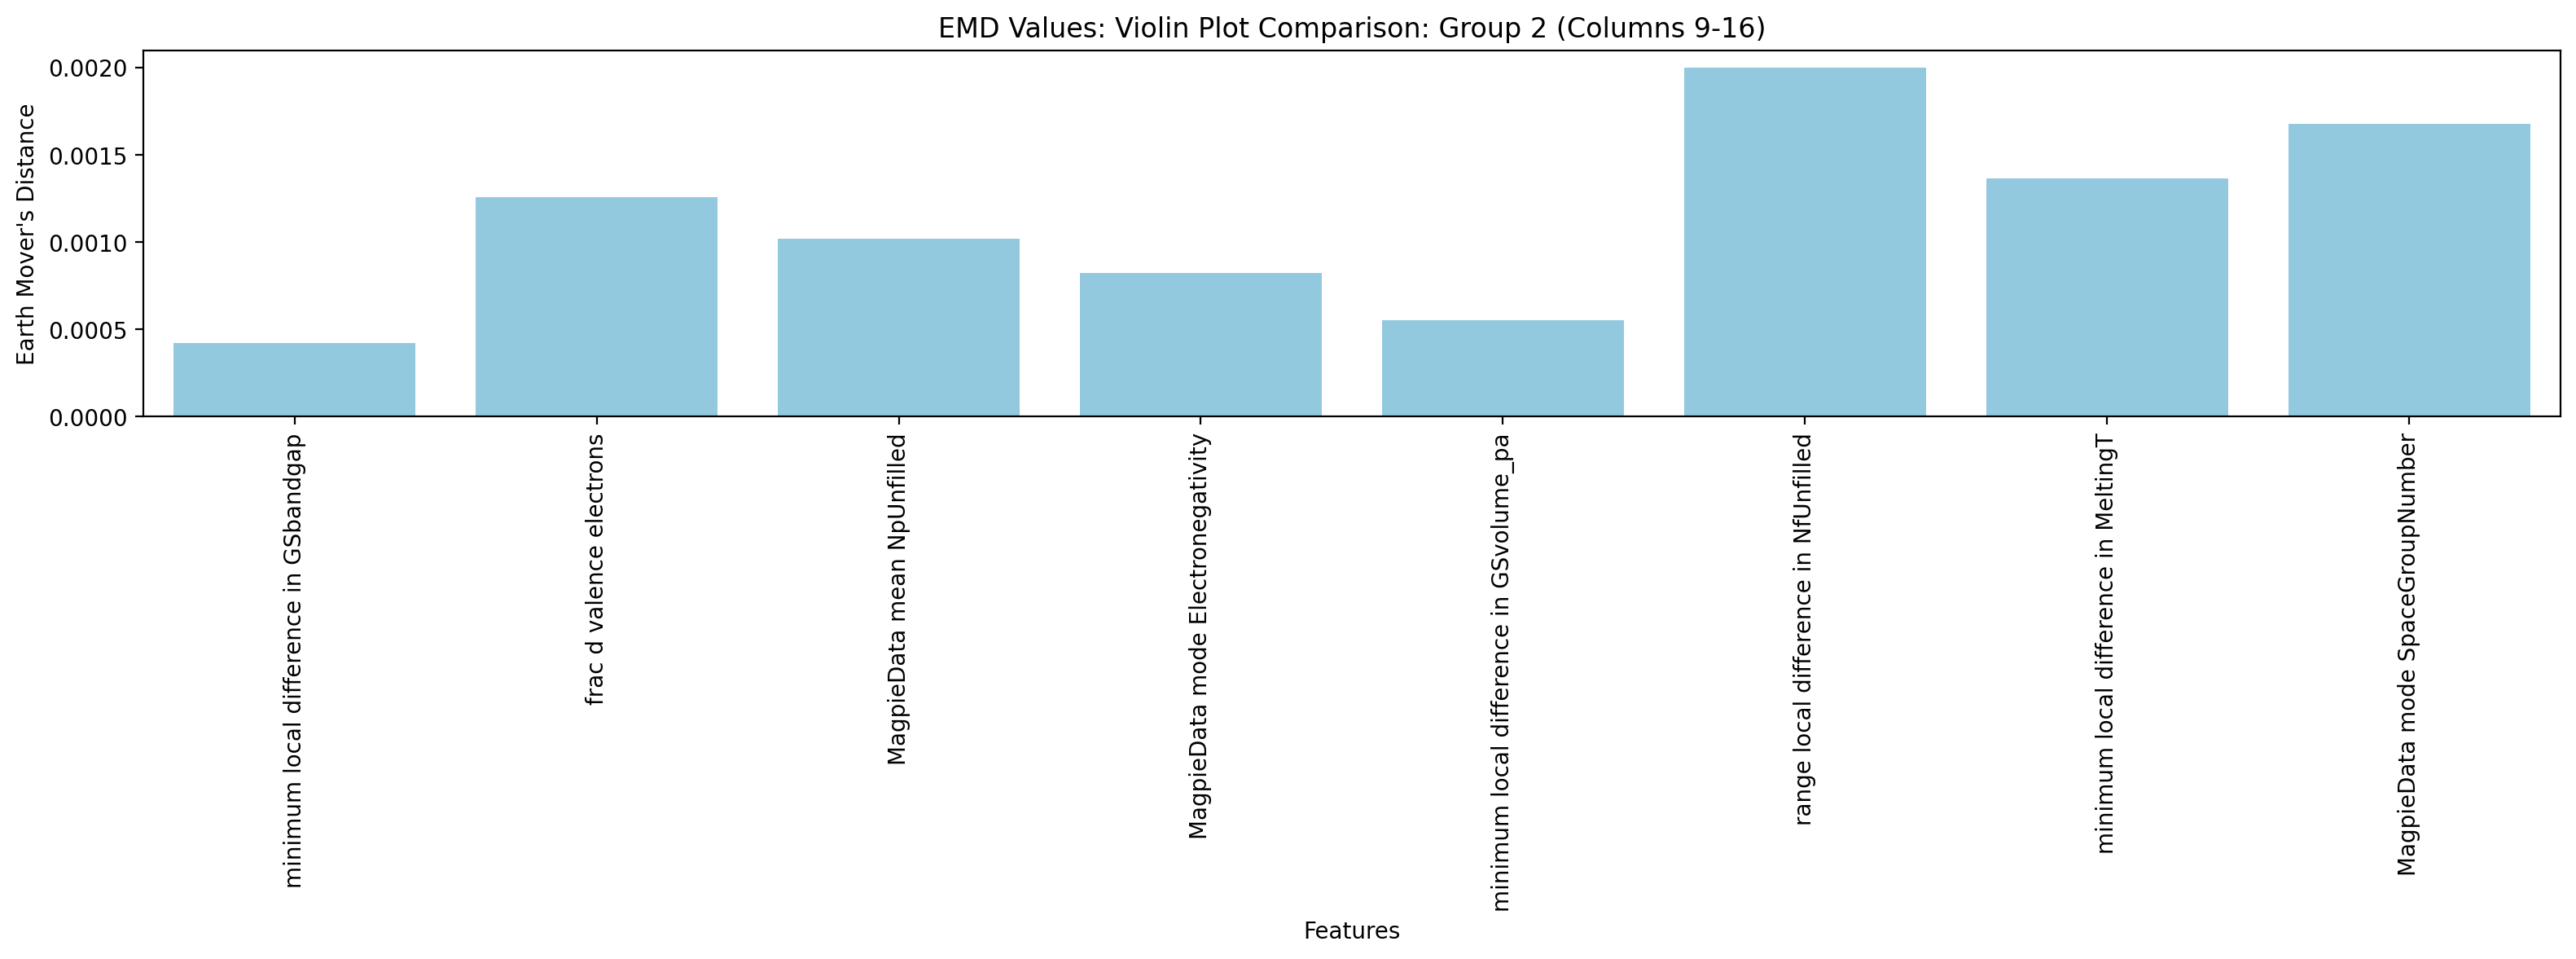

/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/3722296884.py:59: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


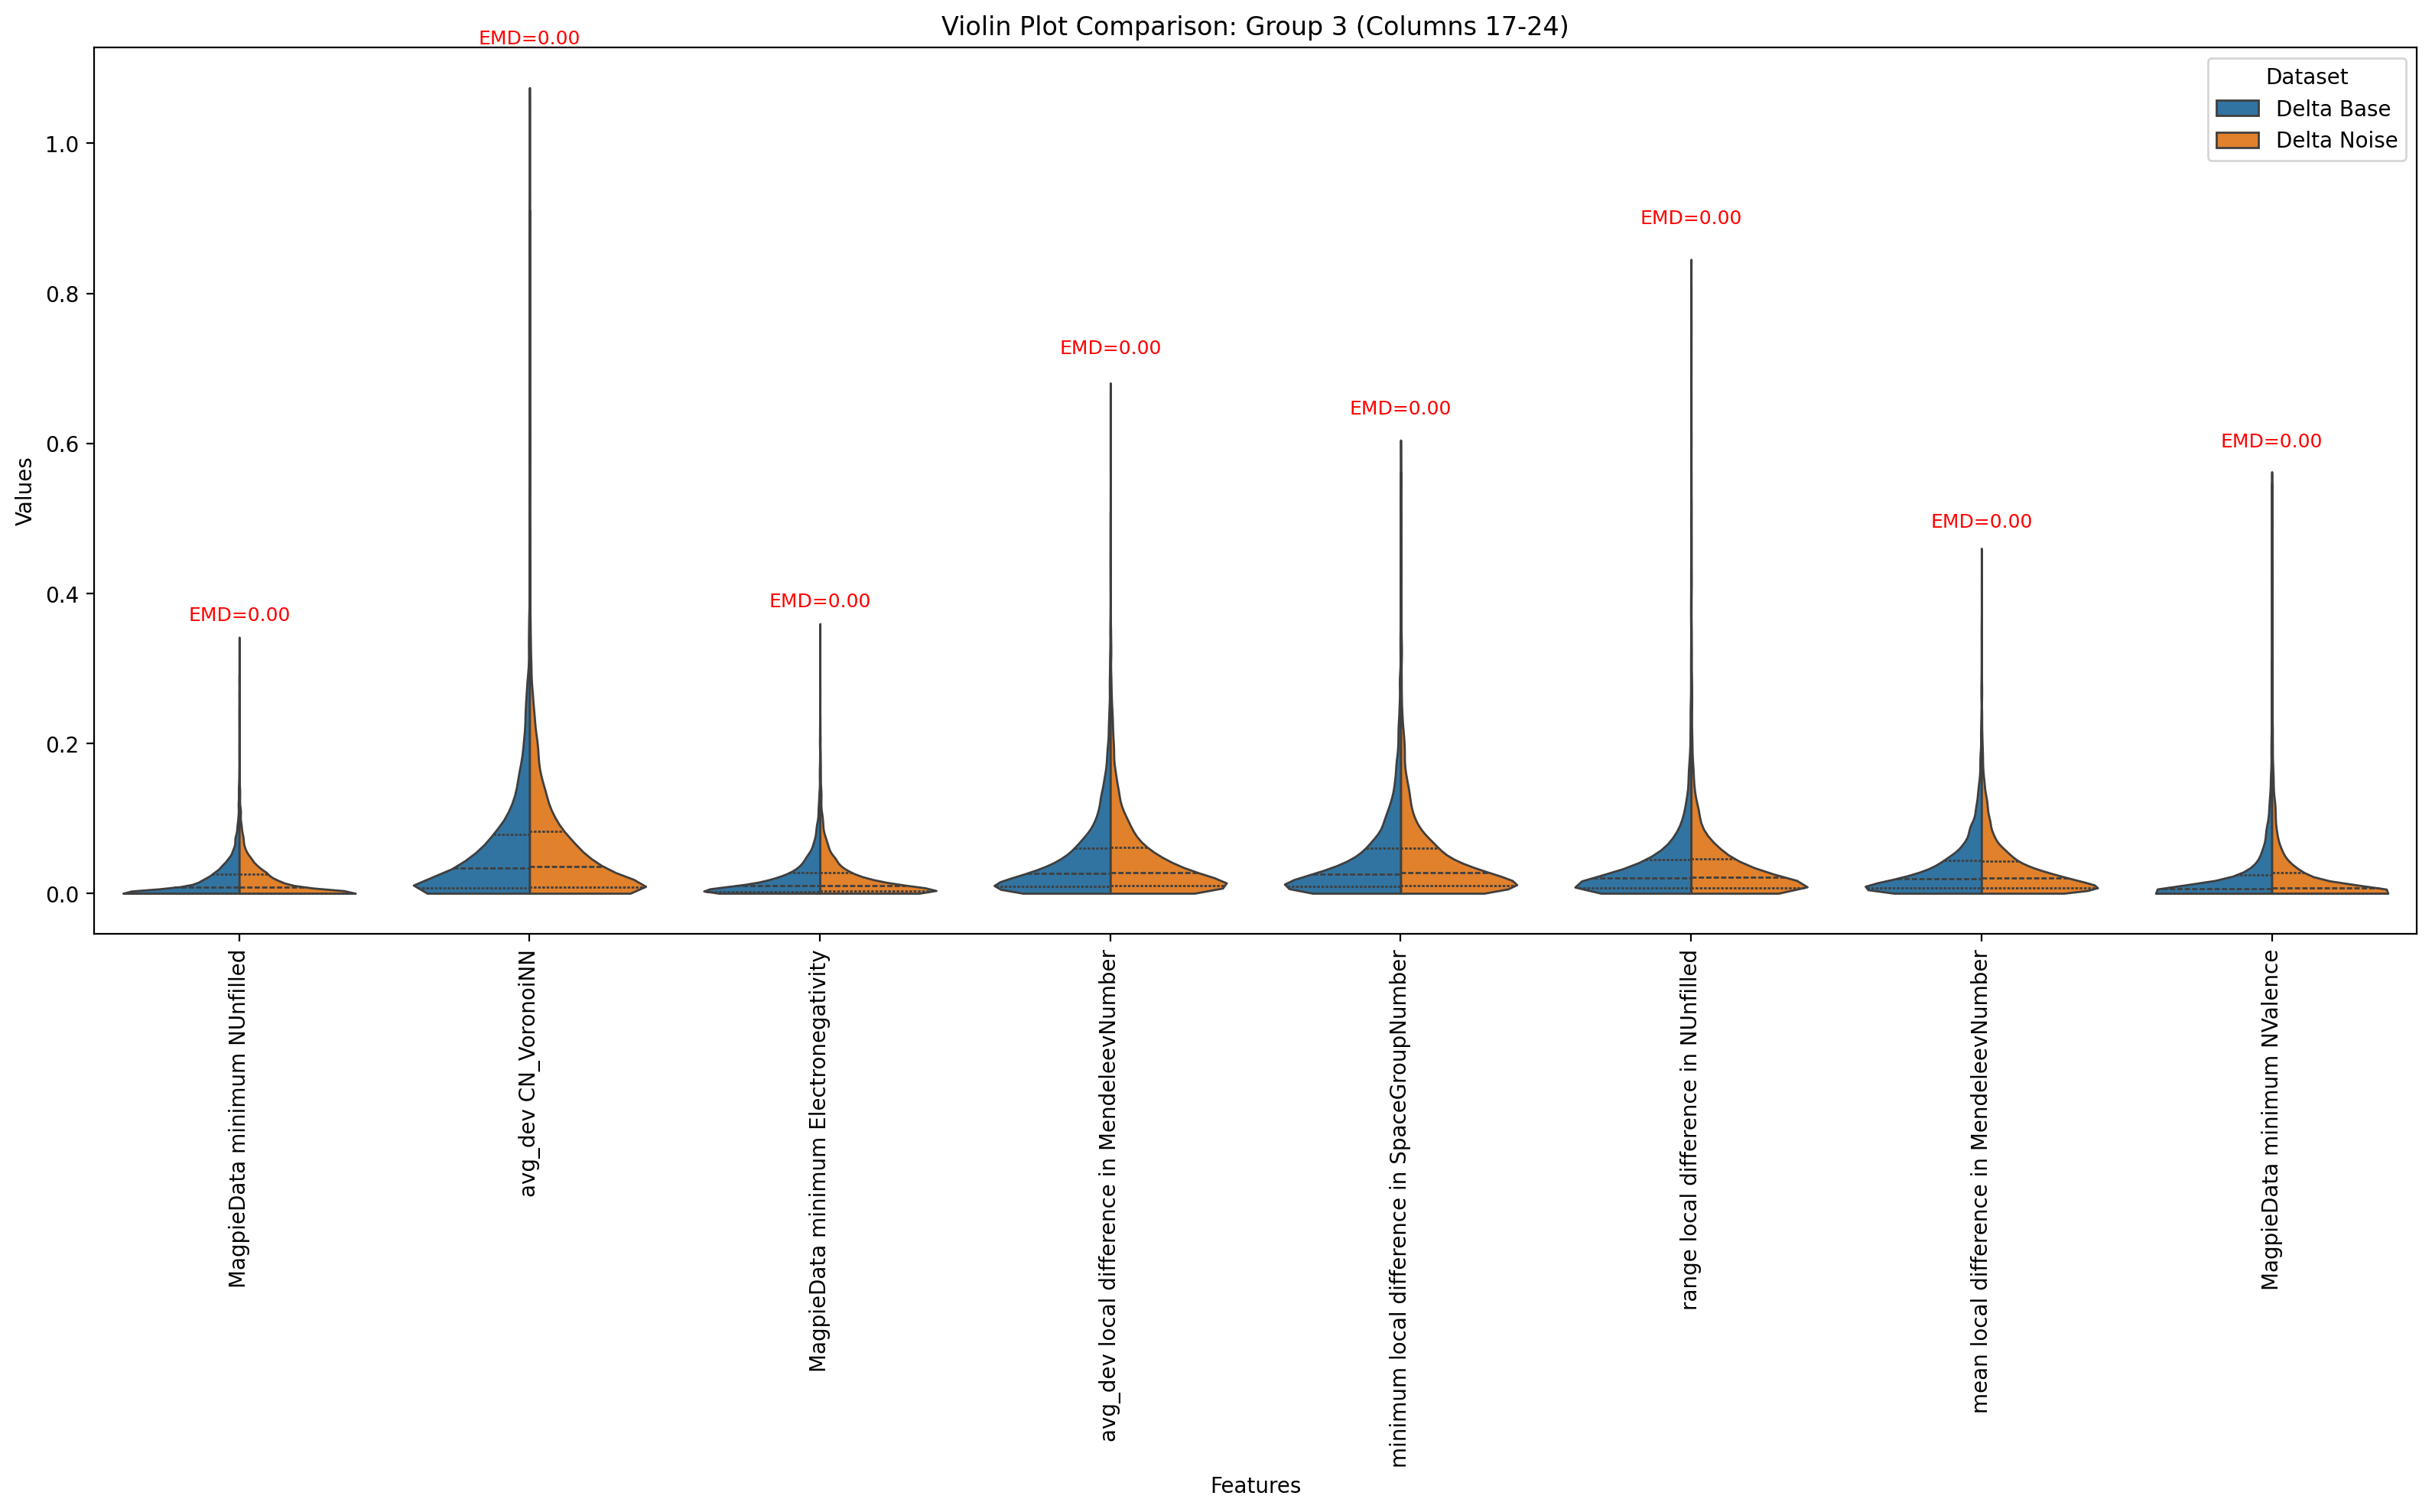

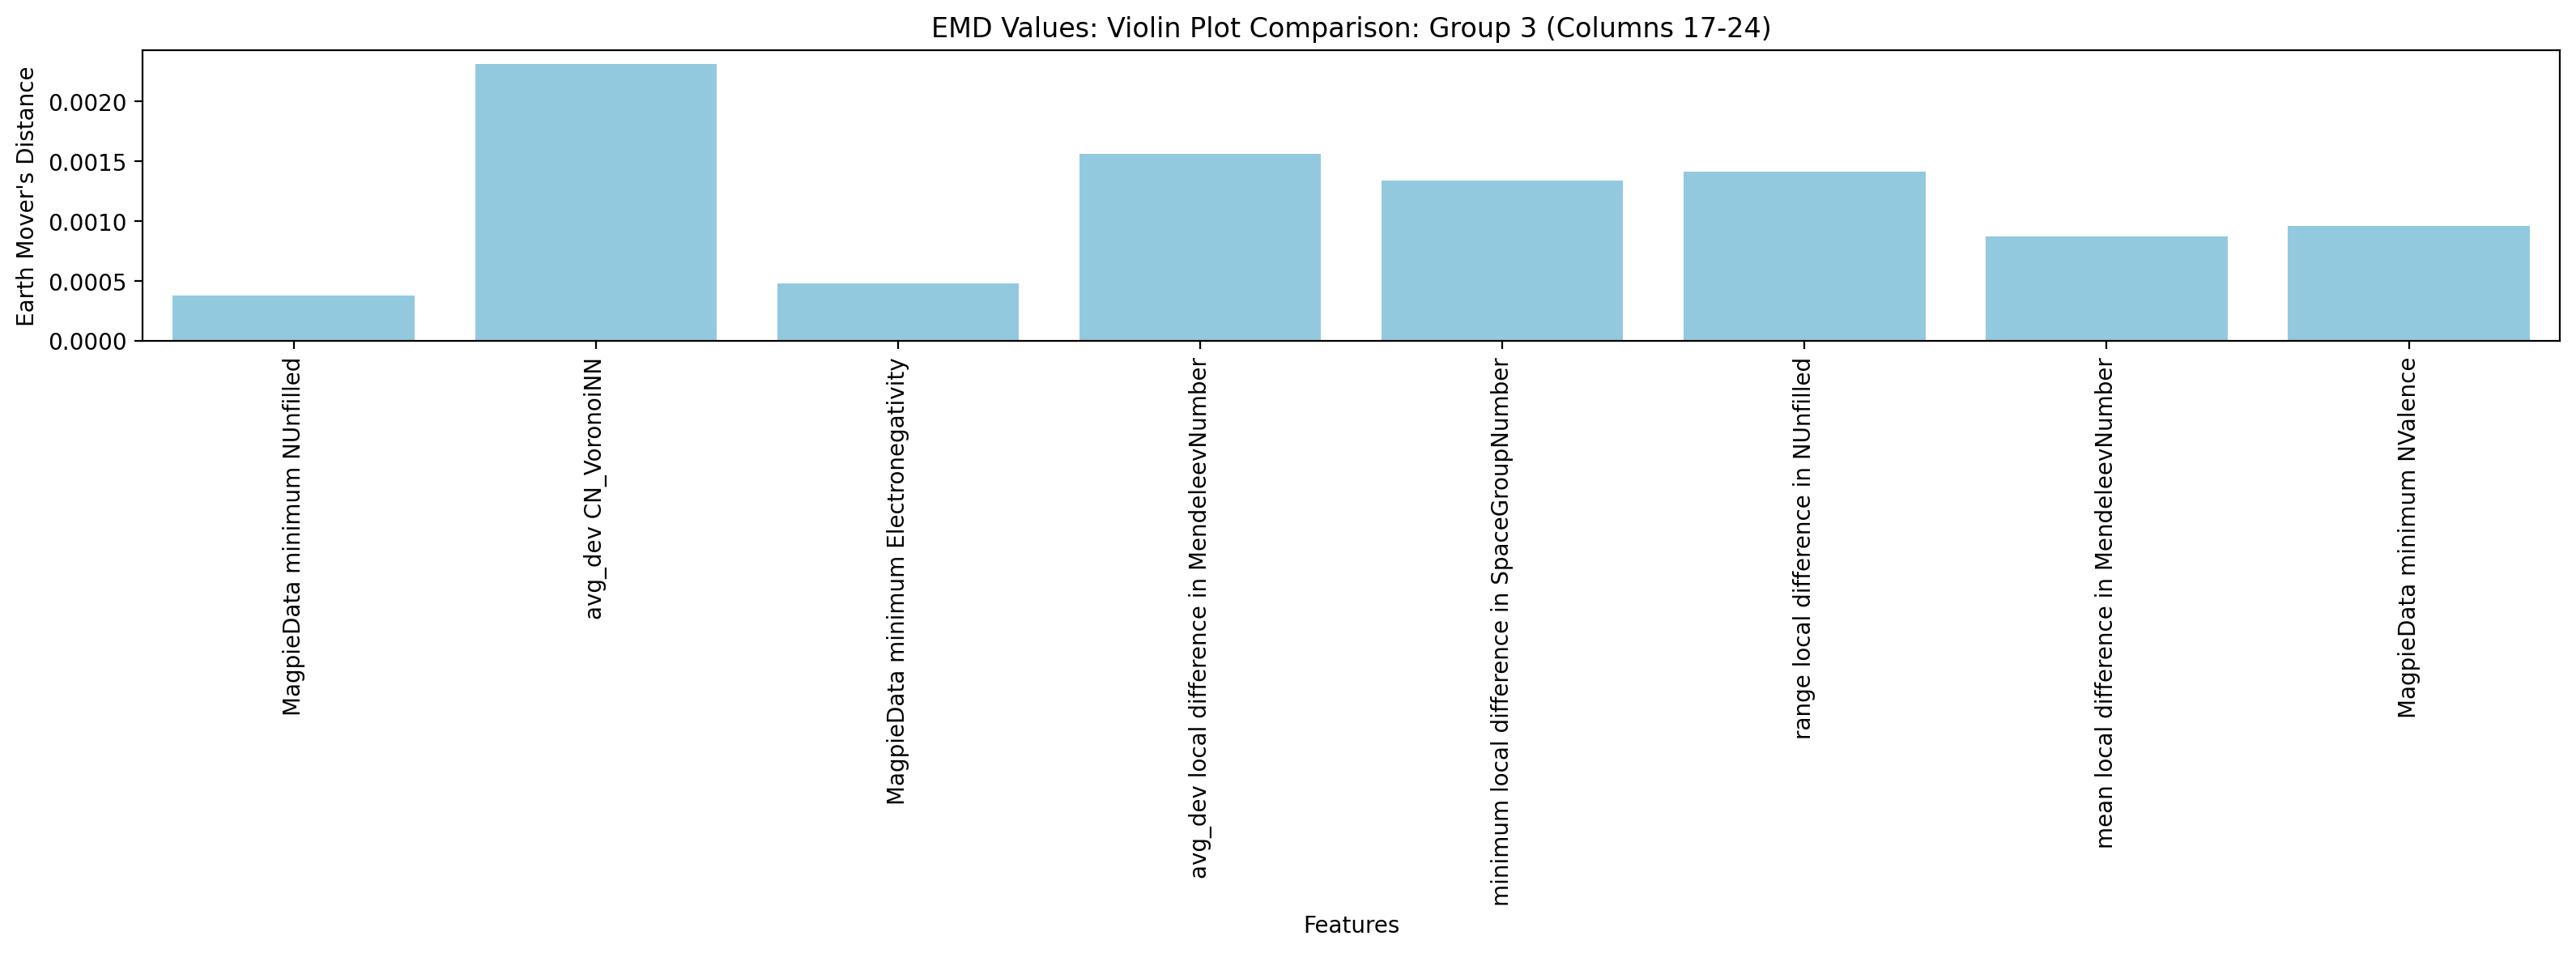

/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/3722296884.py:59: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


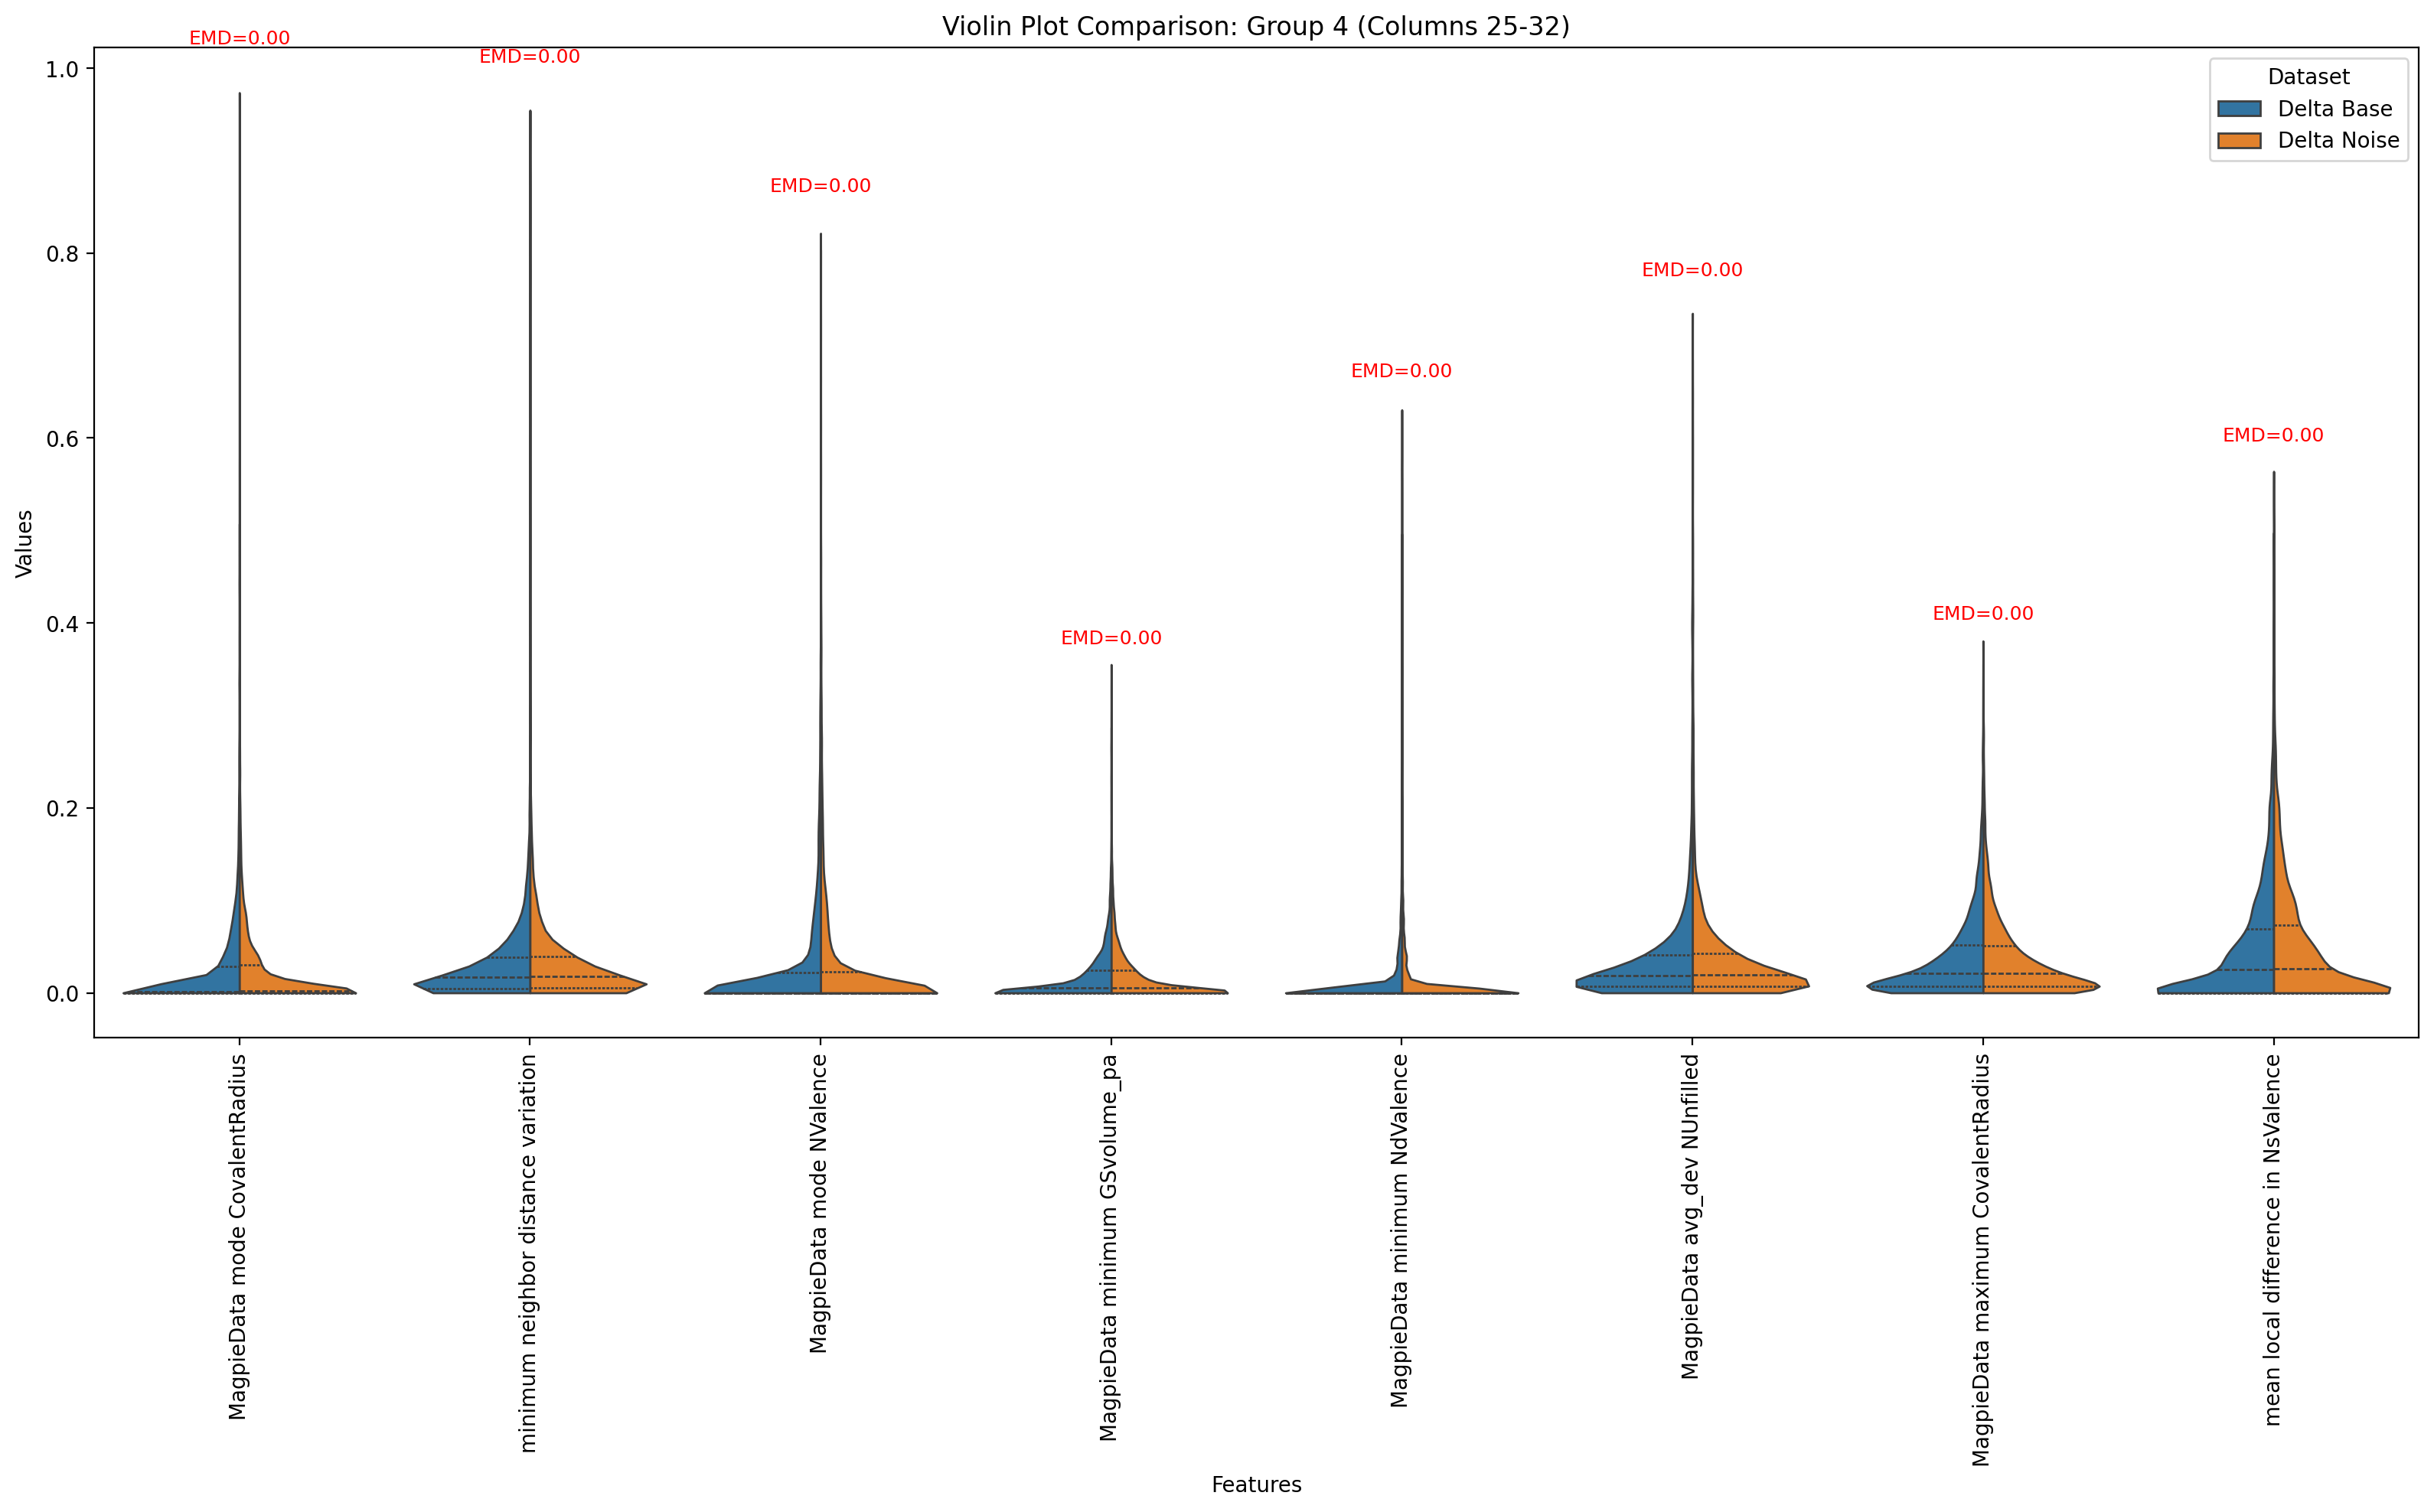

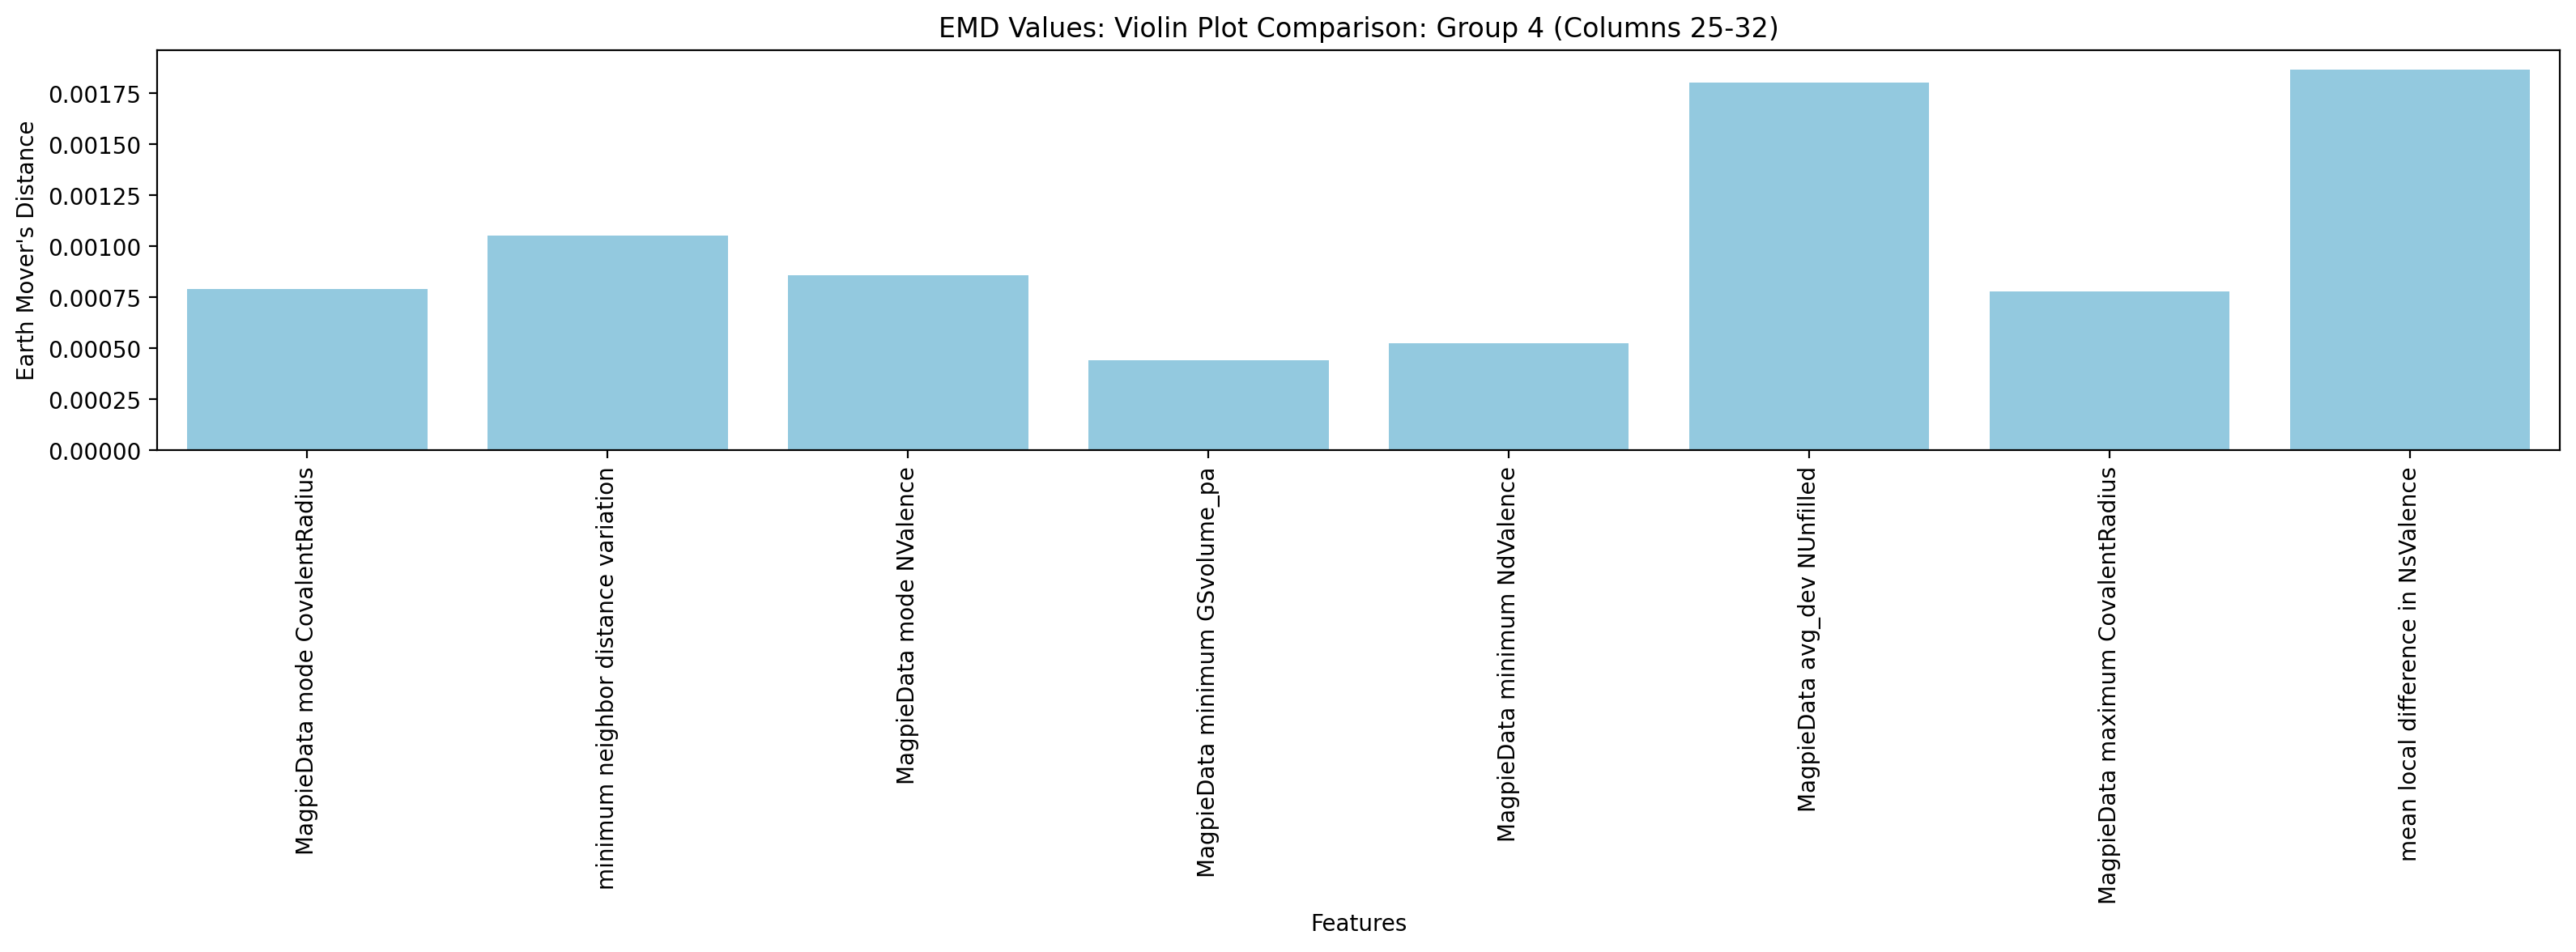

/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/3722296884.py:59: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


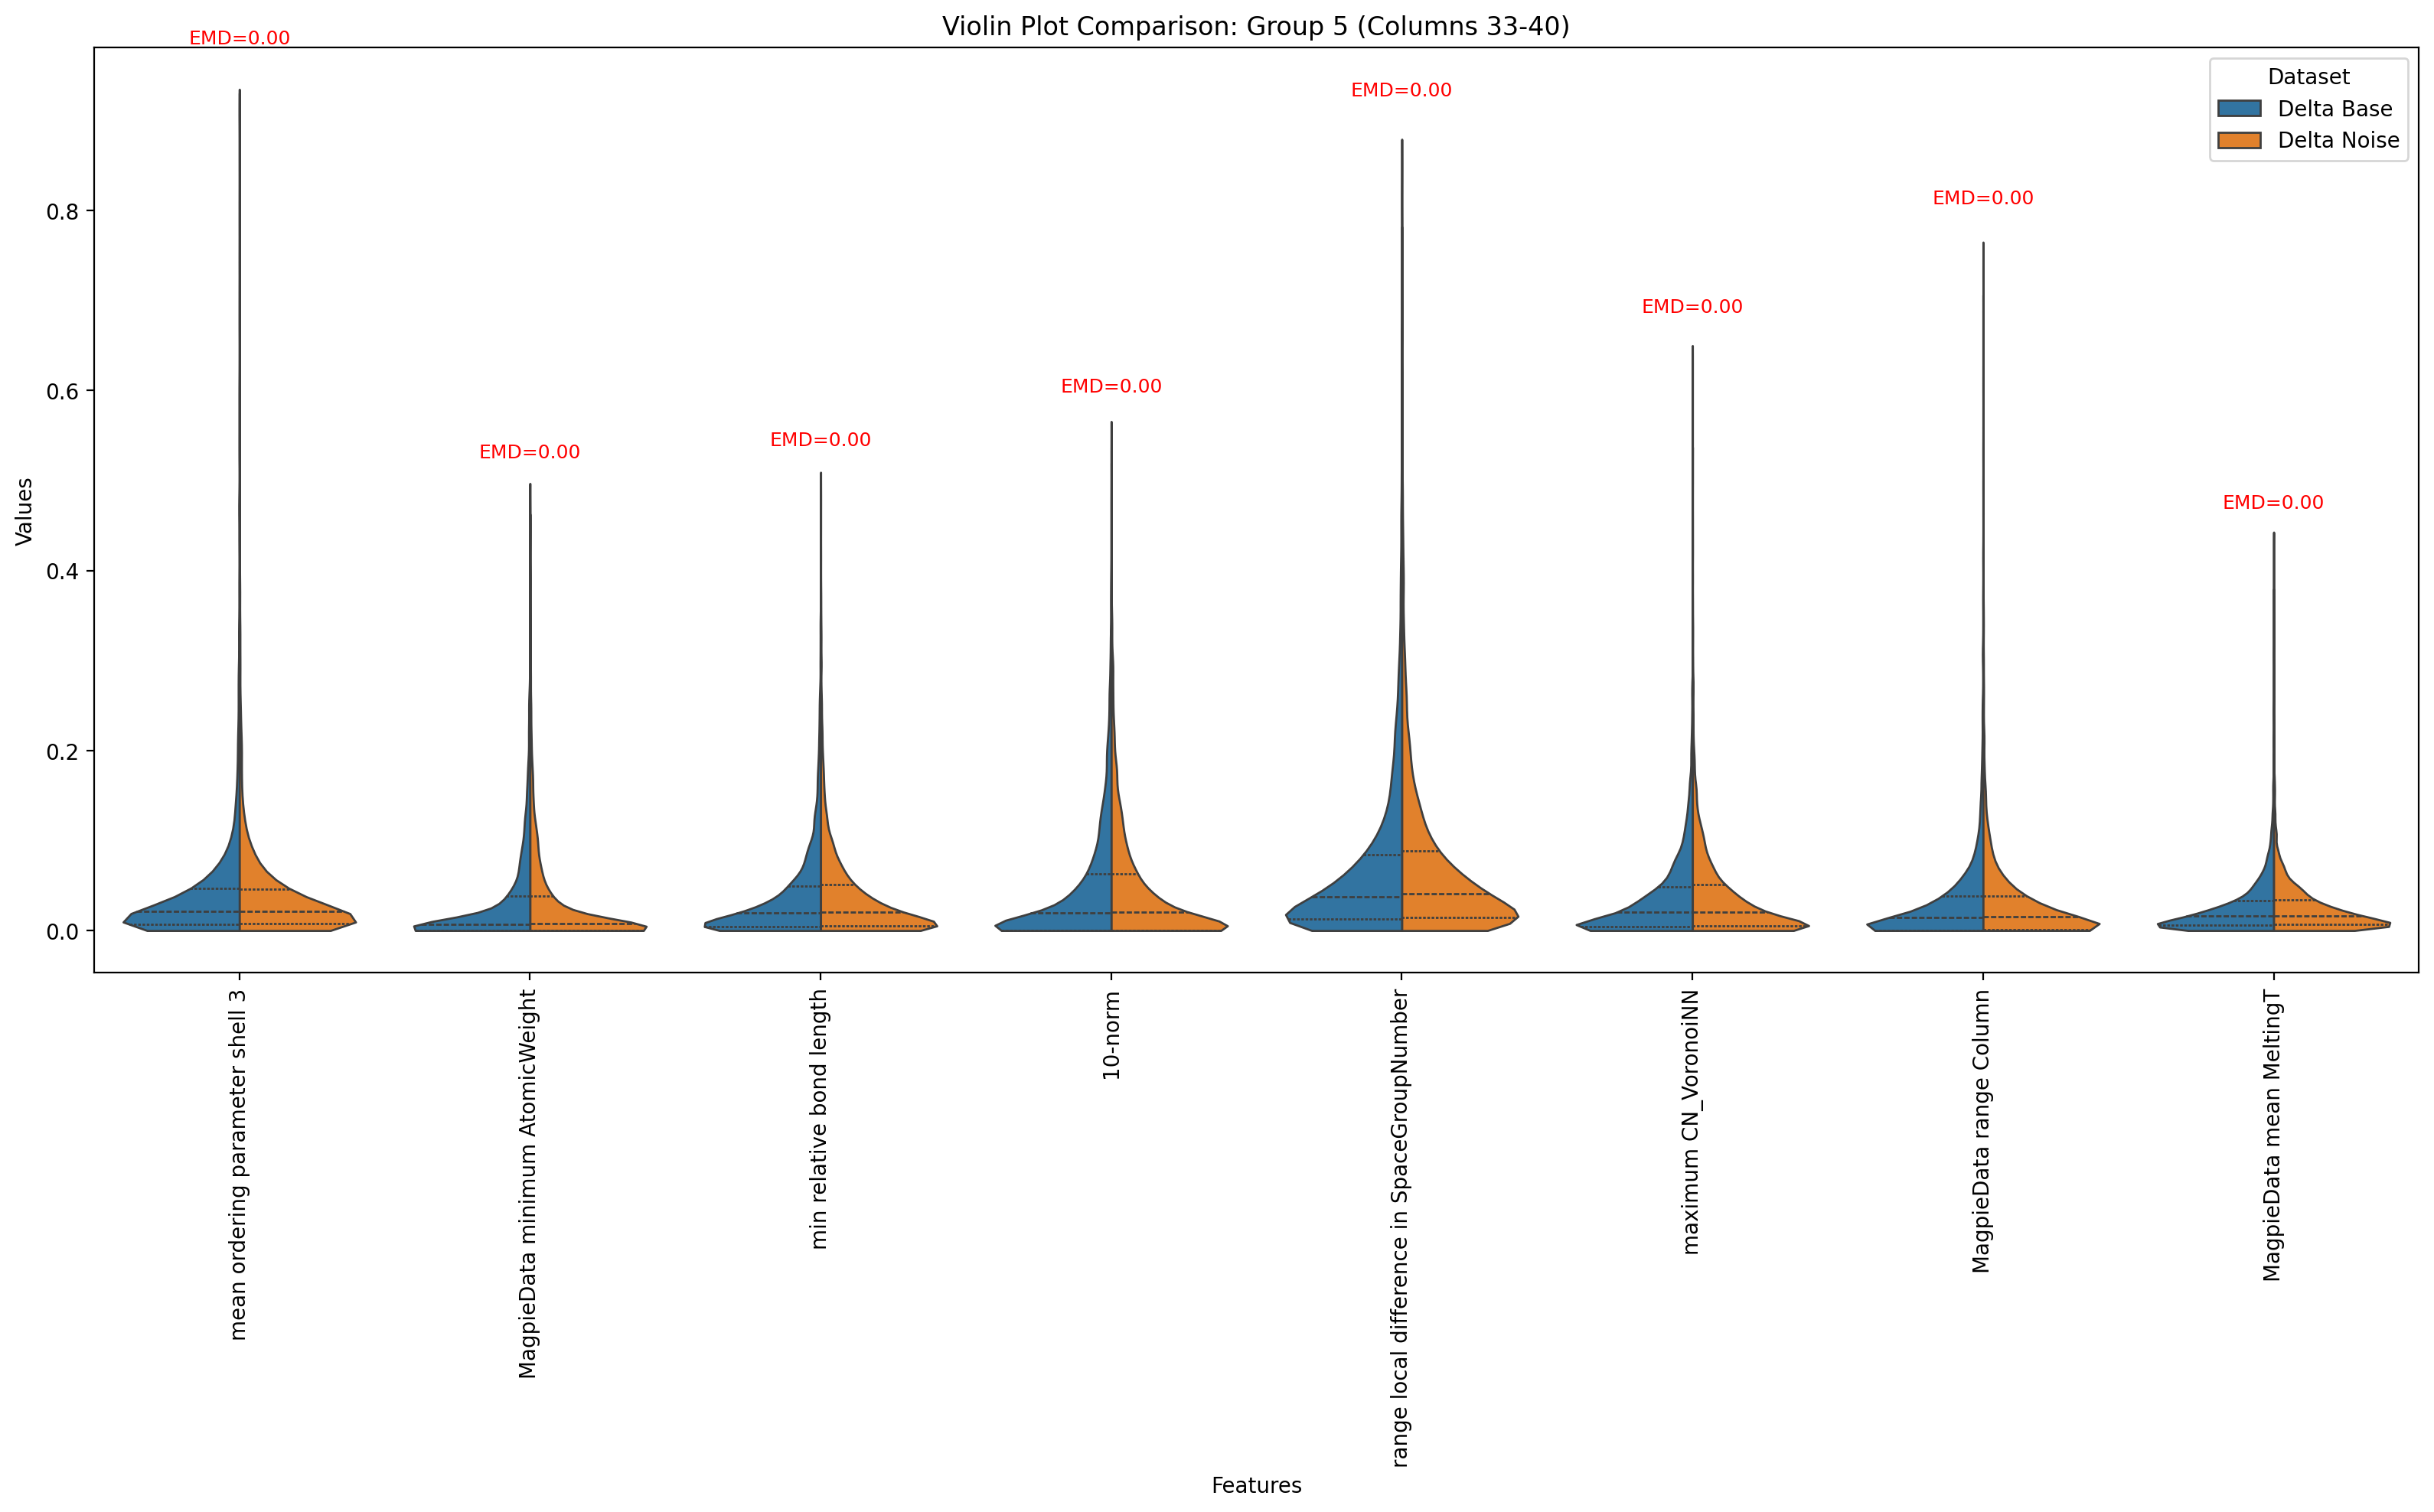

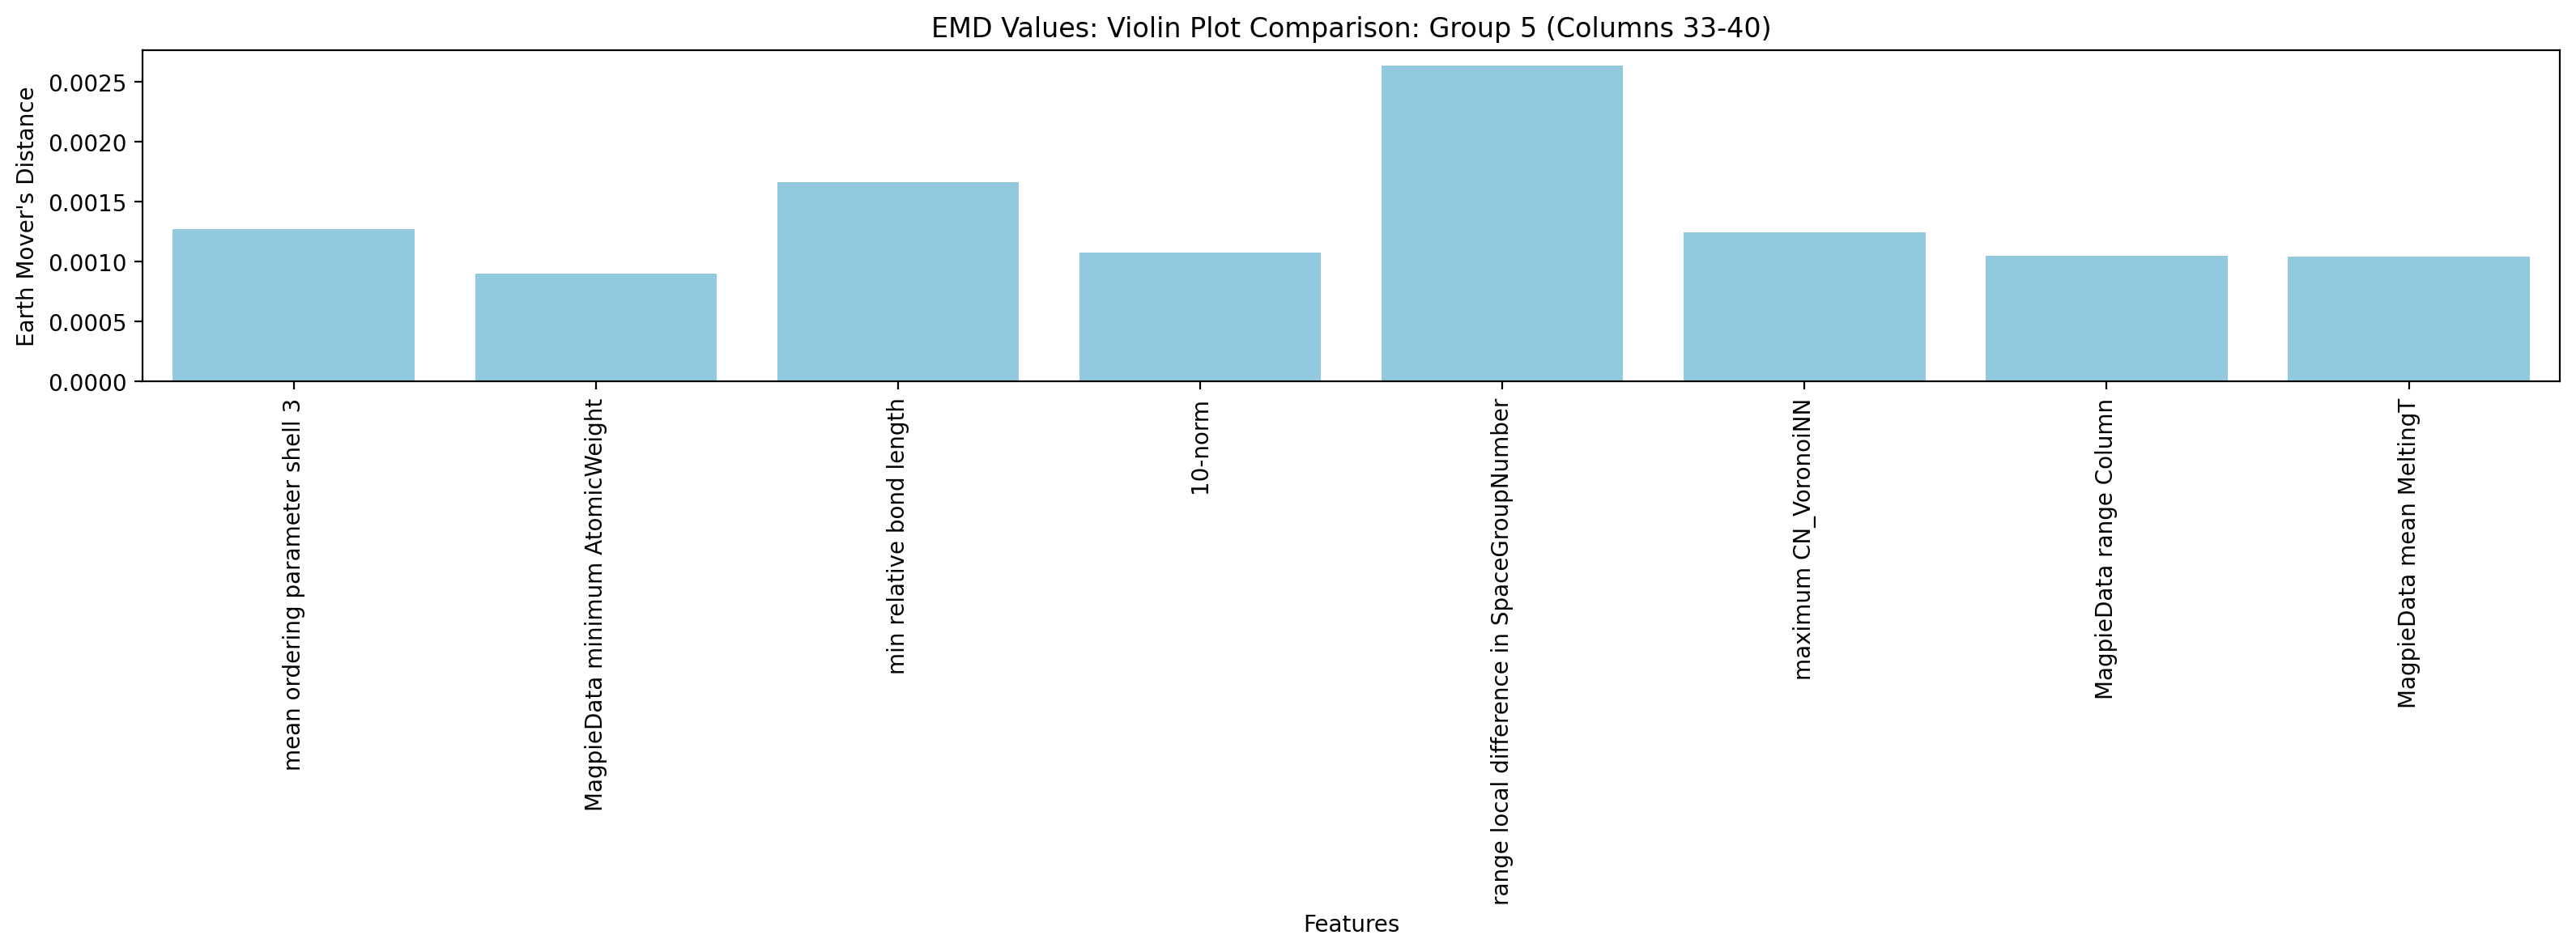

/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/3722296884.py:59: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


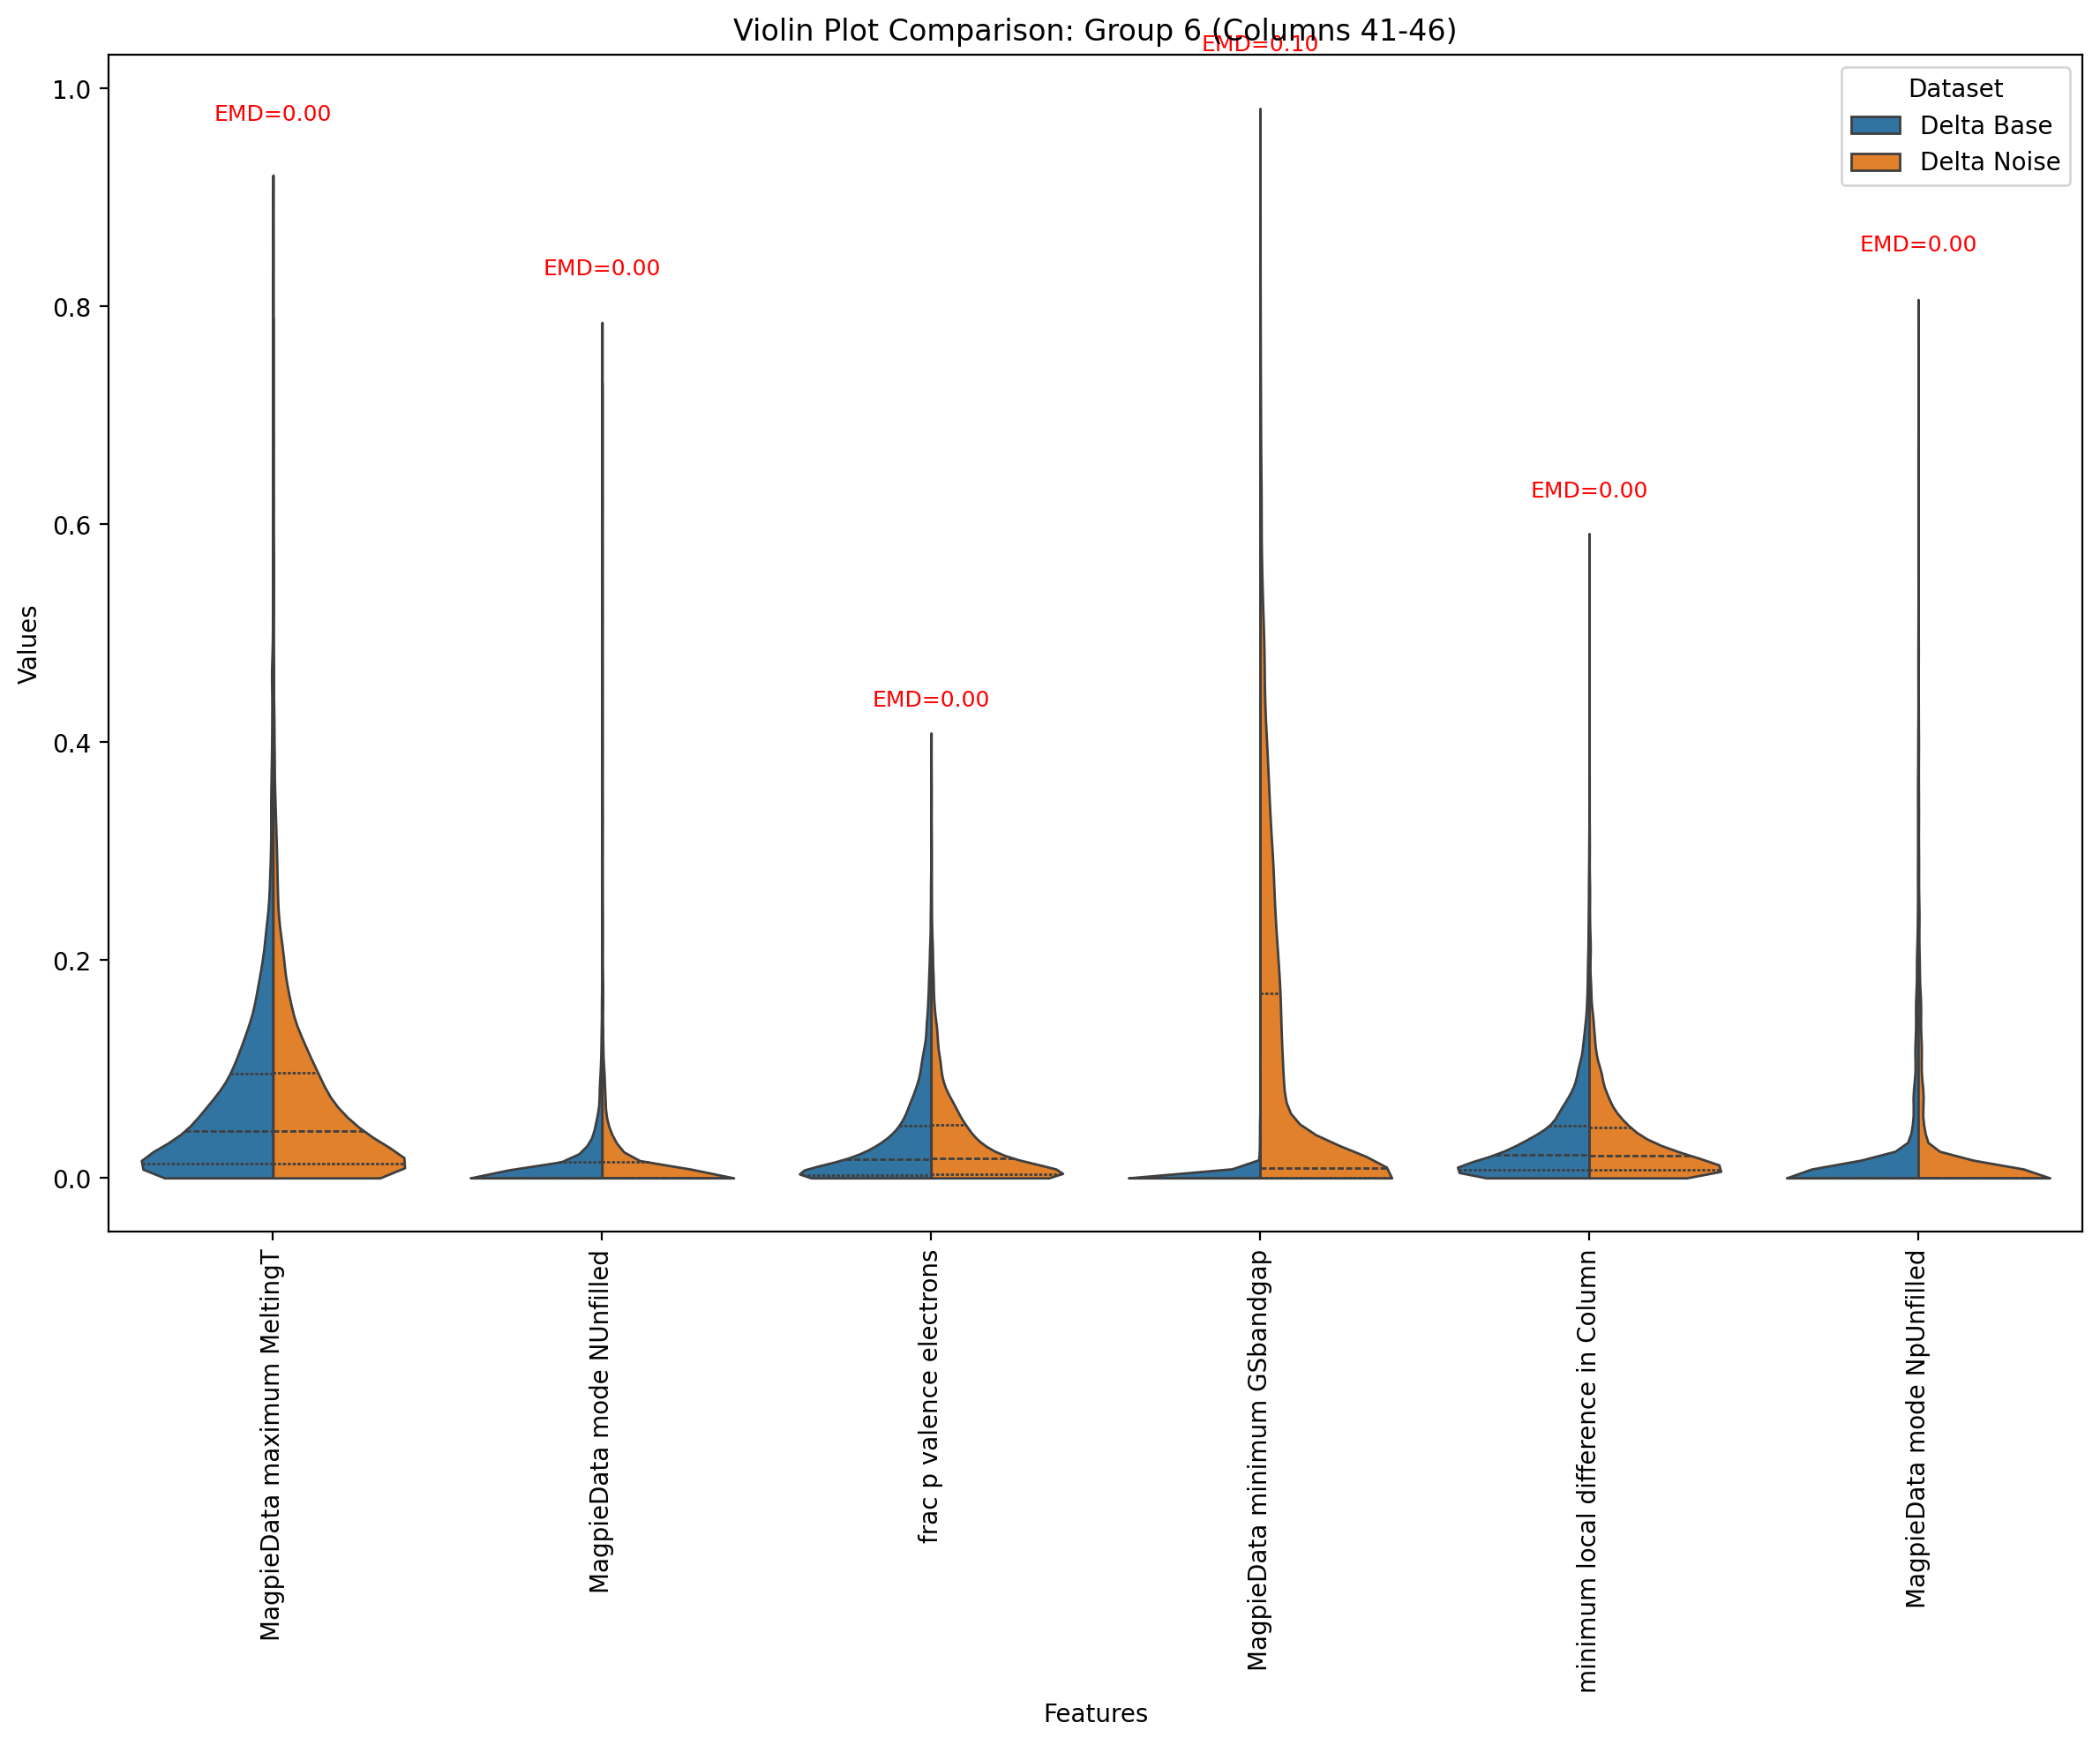

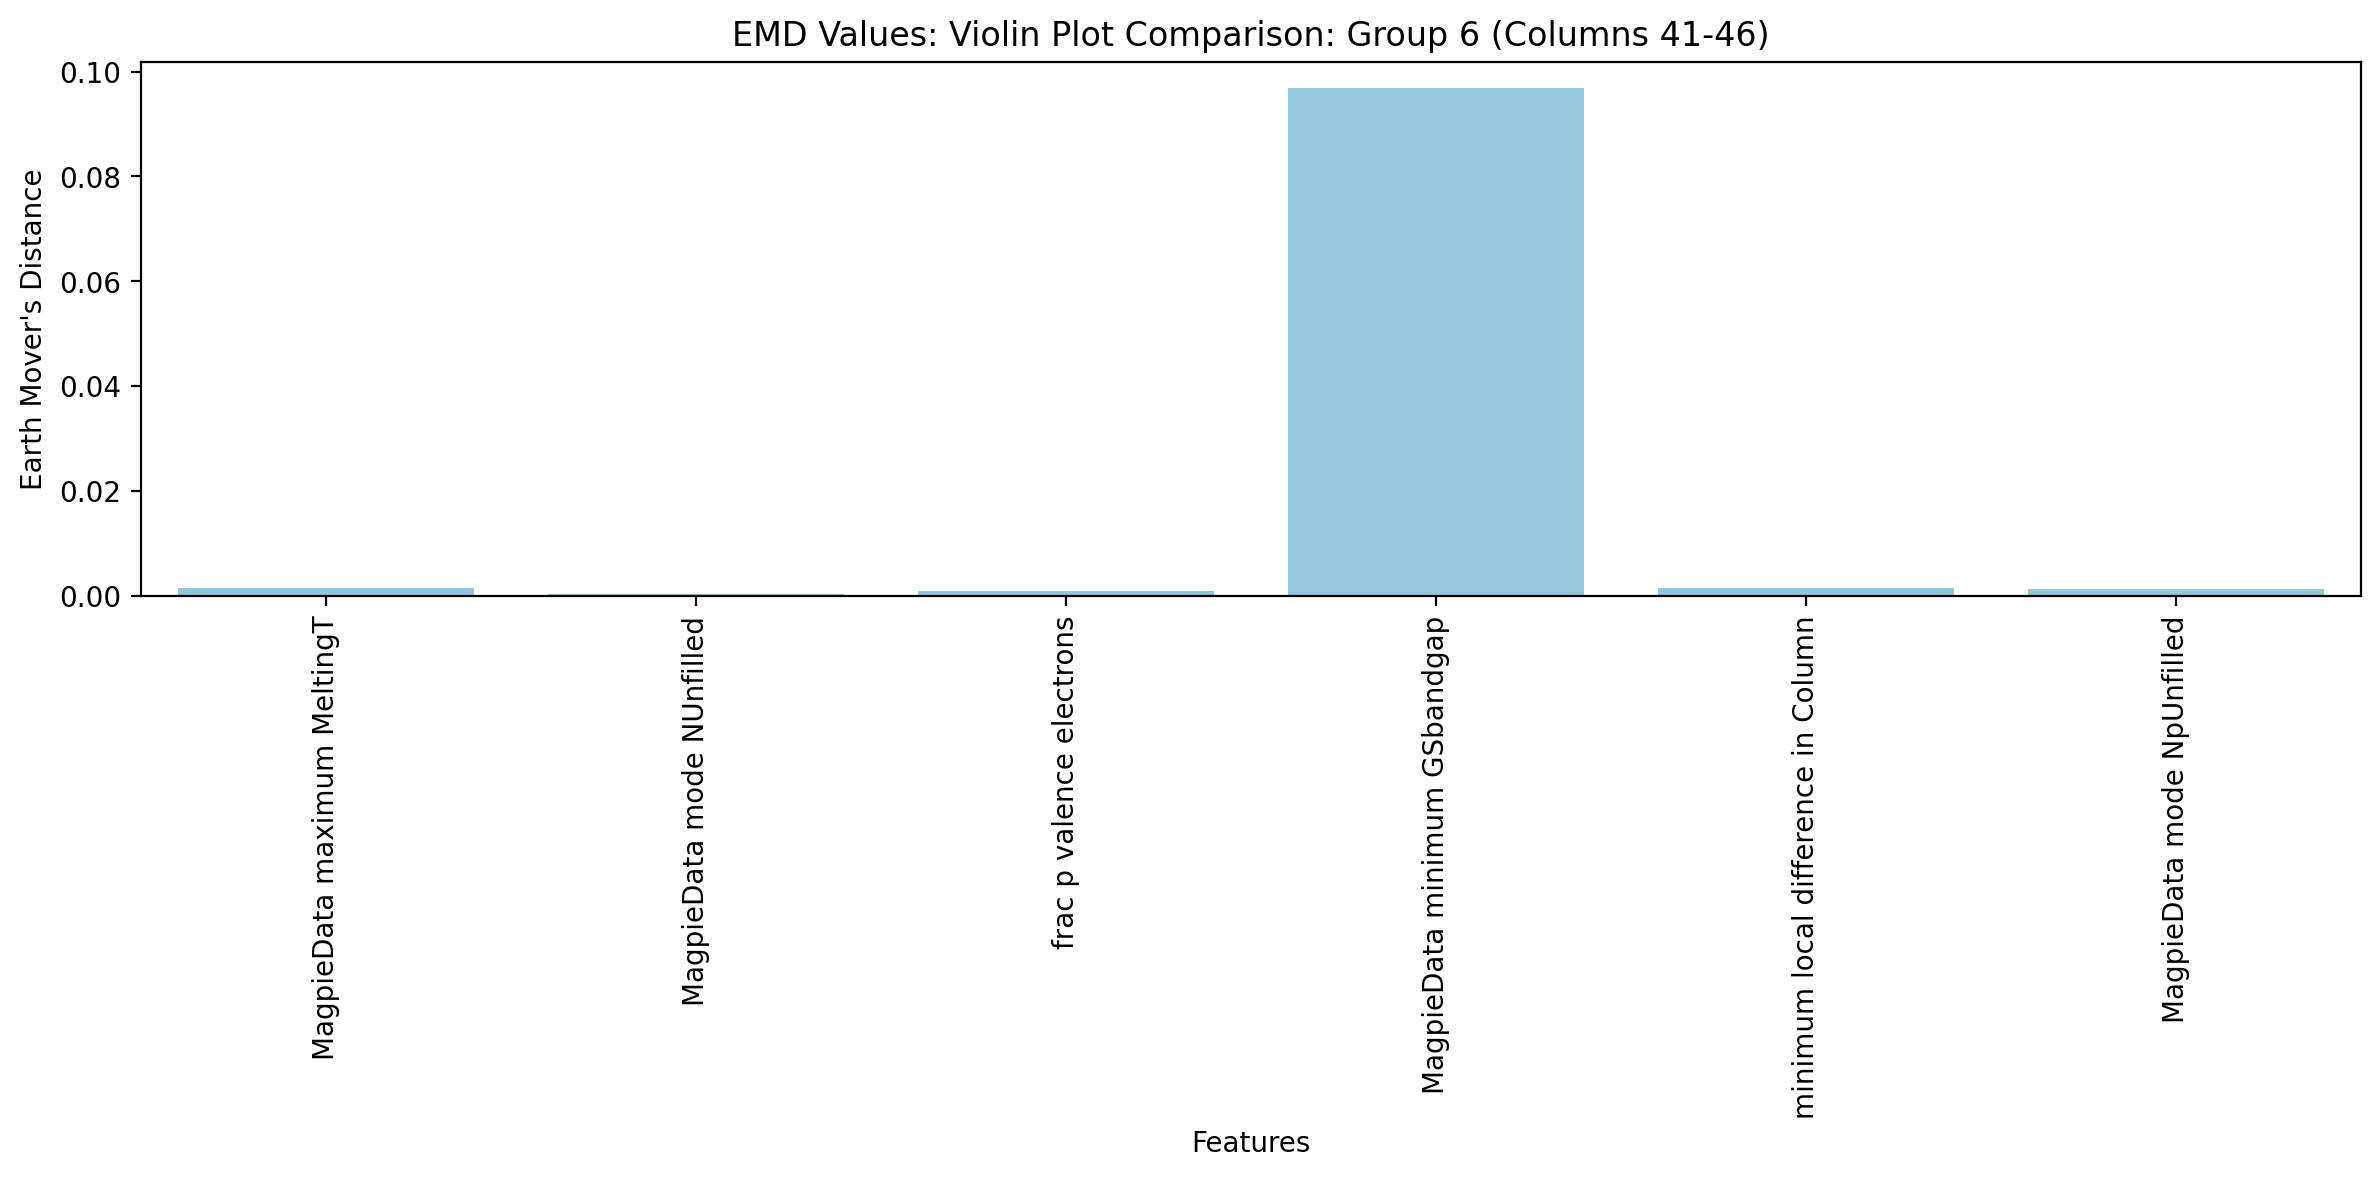

The feature(s) with the largest EMD of 0.0969 are:
 - MagpieData minimum GSbandgap


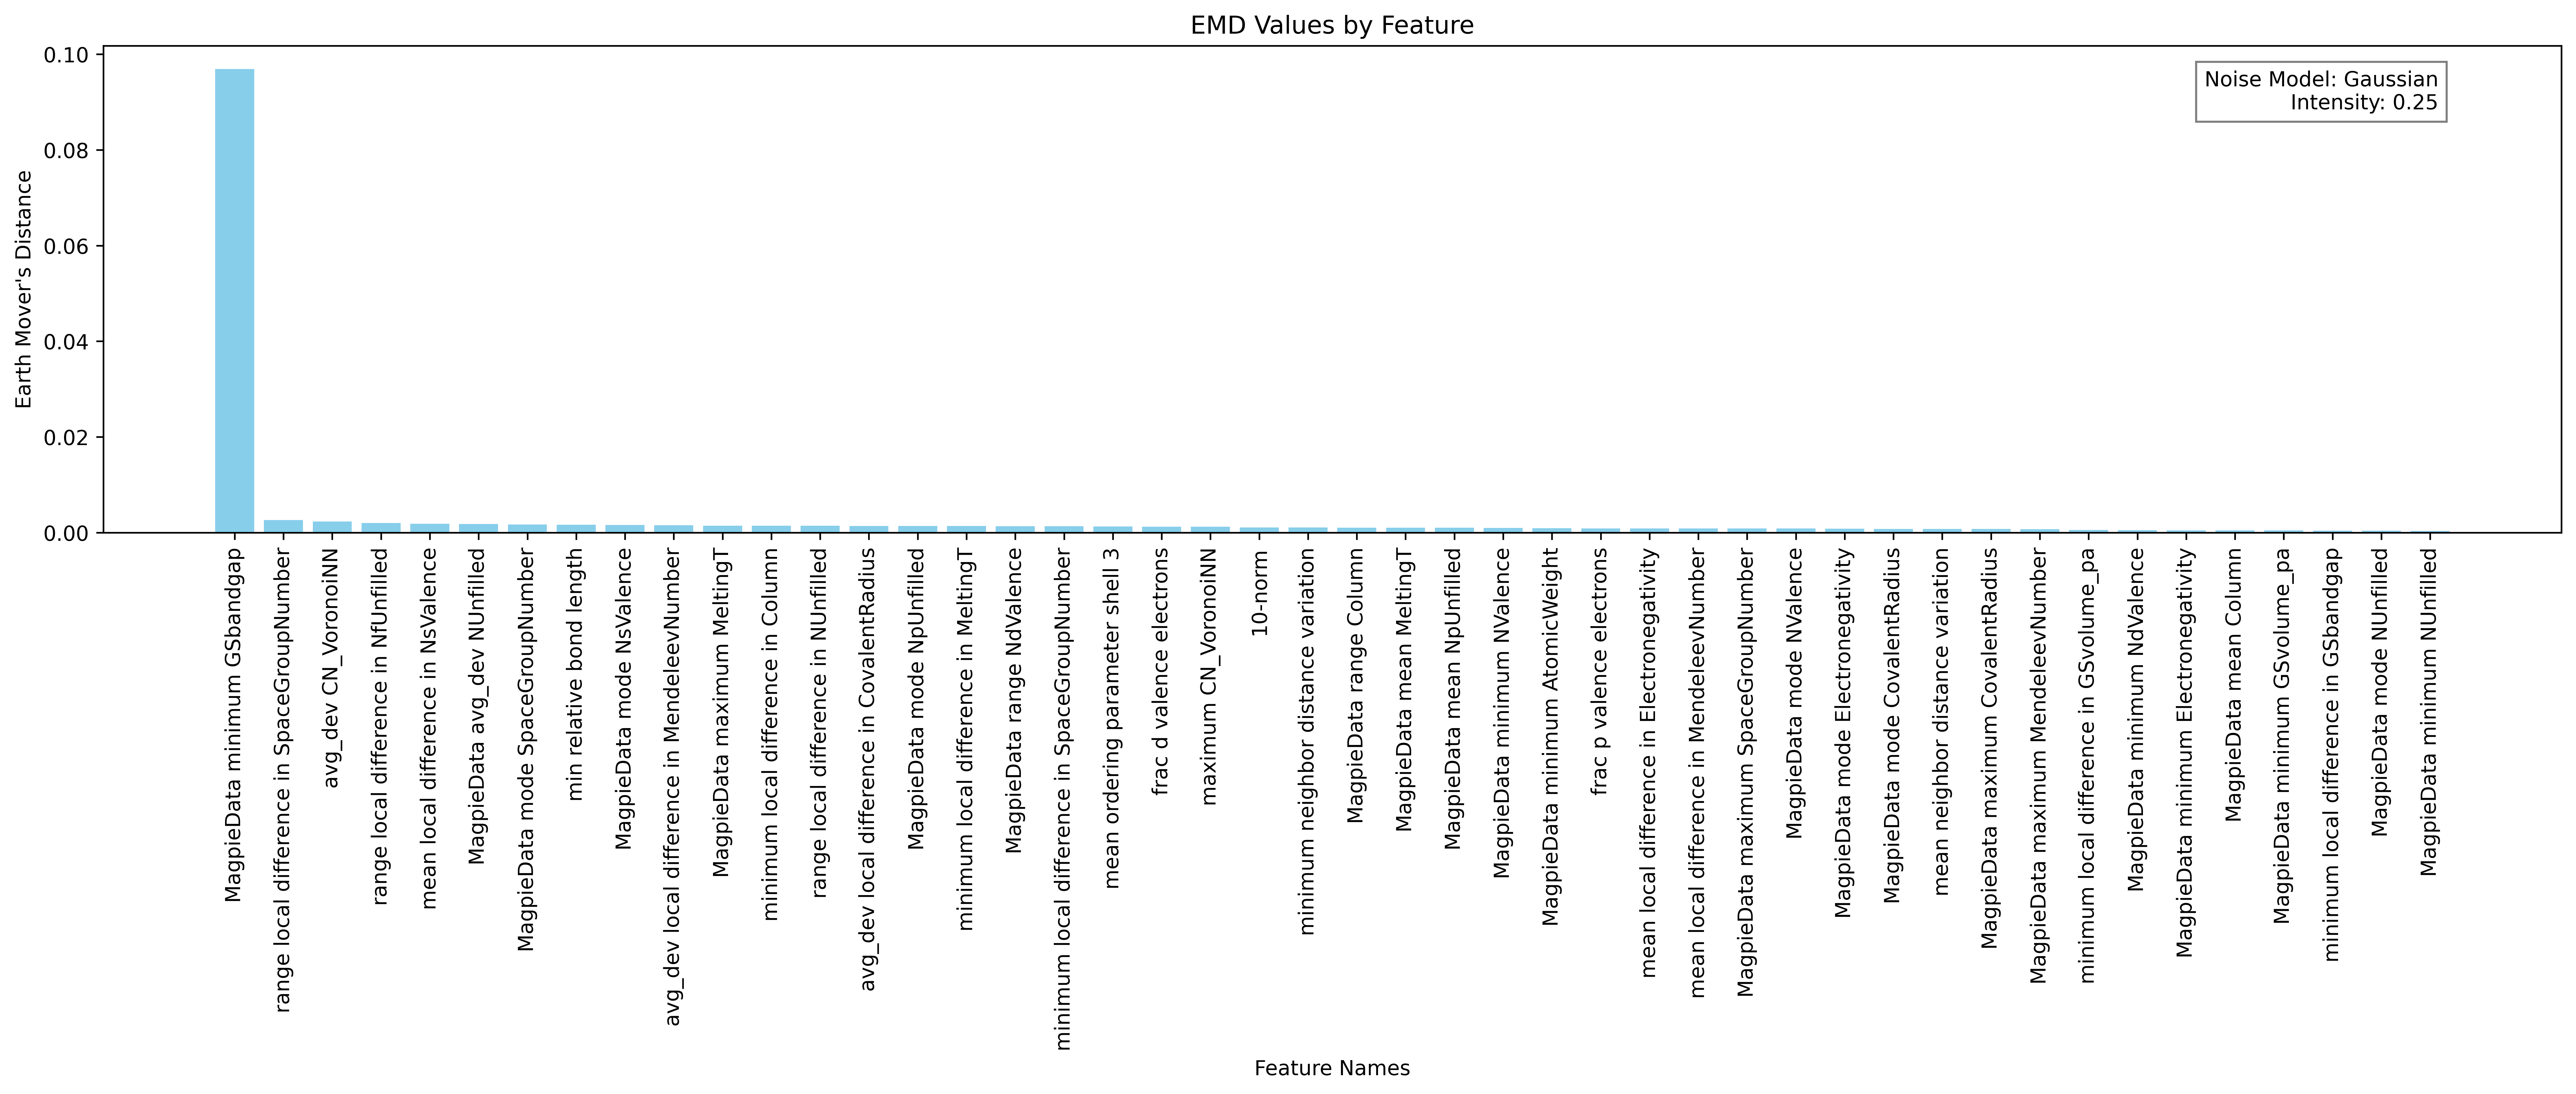

In [ ]:
# Existing variables and data
noisy_feature = 'MagpieData minimum GSbandgap'
delta_noise = results[noisy_feature]["y_test_diffs"]

# Convert delta_base and delta_noise into DataFrames
delta_base = pd.DataFrame(delta_base)
delta_noise = pd.DataFrame(delta_noise)

# Convert column names to strings for consistency
delta_base.columns = delta_base.columns.map(str)
delta_noise.columns = delta_noise.columns.map(str)

# Identify common columns between delta_base and delta_noise
common_columns = delta_base.columns.intersection(delta_noise.columns).tolist()

# Sanitize the noisy_feature name for use in a filename
def sanitize_filename(name):
    return re.sub(r'[^A-Za-z0-9_\-]', '_', name)

sanitized_noisy_feature = sanitize_filename(noisy_feature)

# Adjust the number of columns per group if needed
columns_per_group = 8  # You can adjust this number based on the total number of common columns

# Build groups using common columns
groups = [
    (
        common_columns[i:i+columns_per_group],
        f'Group {j} (Columns {i+1}-{i+len(common_columns[i:i+columns_per_group])})'
    )
    for j, i in enumerate(range(0, len(common_columns), columns_per_group), 1)
]

# Define compute_emd function
def compute_emd(delta_base, delta_noise, columns):
    emd_values = {}
    for feature in columns:
        # Extract the values for the current feature
        base_values = delta_base[feature].dropna()
        noise_values = delta_noise[feature].dropna()
        
        # Compute the Earth Mover's Distance
        emd = wasserstein_distance(base_values, noise_values)
        emd_values[feature] = emd
    return emd_values

# Modify the plot_violin_comparison function
def plot_violin_comparison(delta_base, delta_noise, columns, title, noise_model, intensity, filename, emd_bar_filename):
    num_columns = len(columns)
    plt.figure(figsize=(2 * max(num_columns, 1), 10))  # Increased figure size

    # Combine the two datasets into one for violin plot
    combined_df = pd.concat([
        delta_base[columns].melt(var_name='Feature', value_name='Value').assign(Dataset='Delta Base'),
        delta_noise[columns].melt(var_name='Feature', value_name='Value').assign(Dataset='Delta Noise')
    ], ignore_index=True)

    # Create the violin plot with split violins
    sns.violinplot(
        x='Feature', y='Value', hue='Dataset', data=combined_df,
        inner='quartile', split=True, scale='count', linewidth=1, cut=0,
    )

    # Compute EMD for each feature
    emd_values = compute_emd(delta_base, delta_noise, columns)

    # Annotate EMD on the plot
    for idx, feature in enumerate(columns):
        emd = emd_values[feature]
        # Adjust max_value per feature to ensure the annotation is placed correctly
        max_value = combined_df[combined_df['Feature'] == feature]['Value'].max()
        plt.text(
            idx, max_value * 1.05, f"EMD={emd:.2f}",
            ha='center', va='bottom', fontsize=9, color='red'
        )

    # Additional plot formatting code
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Values')
    plt.xticks(rotation=90)
    plt.legend(title='Dataset', loc='upper right')
    plt.tight_layout()

    # Save the violin plot to the specified filename
    plt.savefig(filename)
    plt.show()

    # Plot the EMD values as a separate bar plot
    plt.figure(figsize=(2 * max(num_columns, 1), 6))  # Increased figure size
    sns.barplot(x=list(emd_values.keys()), y=list(emd_values.values()), color='skyblue')
    plt.title(f'EMD Values: {title}')
    plt.xlabel('Features')
    plt.ylabel('Earth Mover\'s Distance')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(emd_bar_filename)
    plt.show()

# Call the function for each group with unique filenames that include the noisy feature
for idx, (columns, title) in enumerate(groups, 1):
    if not columns:
        print(f"Skipping group {idx} as it contains no common columns.")
        continue  # Skip empty groups
    filename = os.path.join(
        output_dir, 
        f'violin_comparison_{noise_model}_{intensity}_{sanitized_noisy_feature}_group{idx}.png'
    )
    emd_bar_filename = os.path.join(
        output_dir, 
        f'emd_values_{noise_model}_{intensity}_{sanitized_noisy_feature}_group{idx}.png'
    )
    plot_violin_comparison(
        delta_base, delta_noise, columns, f'Violin Plot Comparison: {title}',
        noise_model, intensity, filename, emd_bar_filename
    )

# Compute EMD values for all common features
all_columns = common_columns
emd_values_all = compute_emd(delta_base, delta_noise, all_columns)

# Find the maximum EMD value
max_emd_value = max(emd_values_all.values())

# Find all features that have the maximum EMD value
max_emd_features = [feature for feature, emd in emd_values_all.items() if emd == max_emd_value]

# Print out the feature(s) with the largest EMD and their value
print(f"The feature(s) with the largest EMD of {max_emd_value:.4f} are:")
for feature in max_emd_features:
    print(f" - {feature}")

# Sort EMD values in decreasing order
sorted_emd_values = dict(sorted(emd_values_all.items(), key=lambda item: item[1], reverse=True))

# Create a figure with larger size and high dpi for better quality
plt.figure(figsize=(18, 8), dpi=300)
plt.bar(sorted_emd_values.keys(), sorted_emd_values.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Earth Mover\'s Distance')
plt.title('EMD Values by Feature')

# Add text for noise model and intensity
plt.text(
    0.95, 0.95, f'Noise Model: {noise_model}\nIntensity: {intensity}',
    horizontalalignment='right', verticalalignment='top',
    transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5)
)

# Ensure layout is tight before saving
plt.tight_layout(pad=3.0)  # Add padding for better layout

# Save the plot to the output directory
output_path = os.path.join(
    output_dir, 
    f'emd_values_{noise_model}_{intensity}_{sanitized_noisy_feature}_all_features.png'
)
plt.savefig(output_path)

# Display the plot
plt.close()

# violine plots for selected features

/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/1138563575.py:79: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(
/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/1138563575.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped_labels)


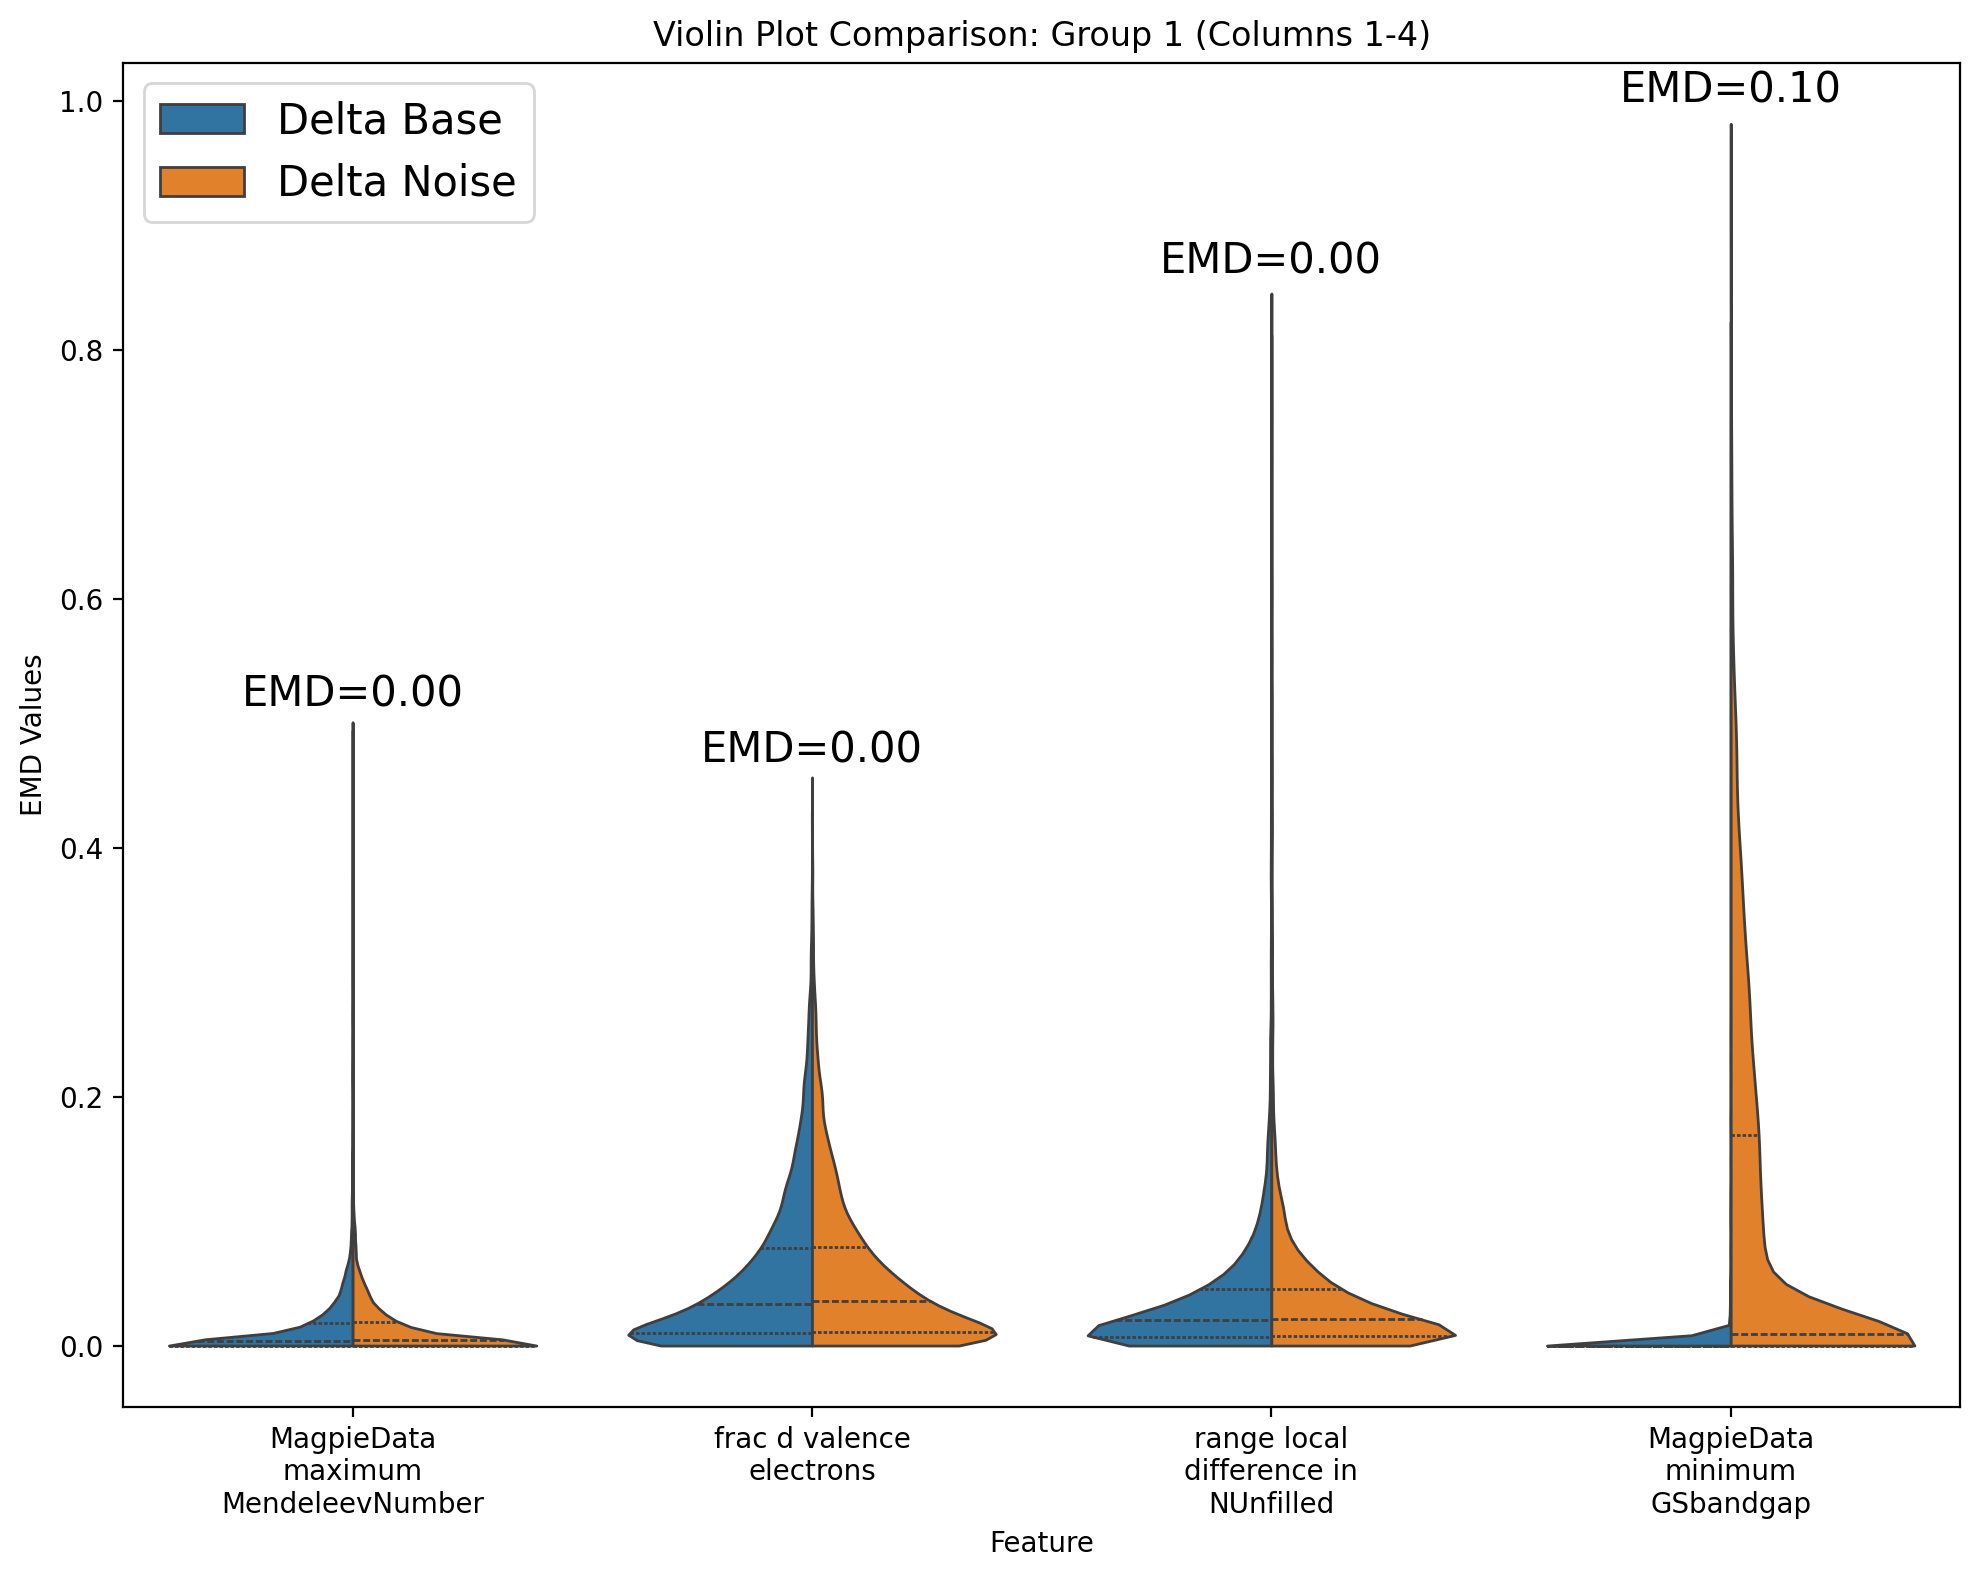

/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/1138563575.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(wrapped_bar_labels)


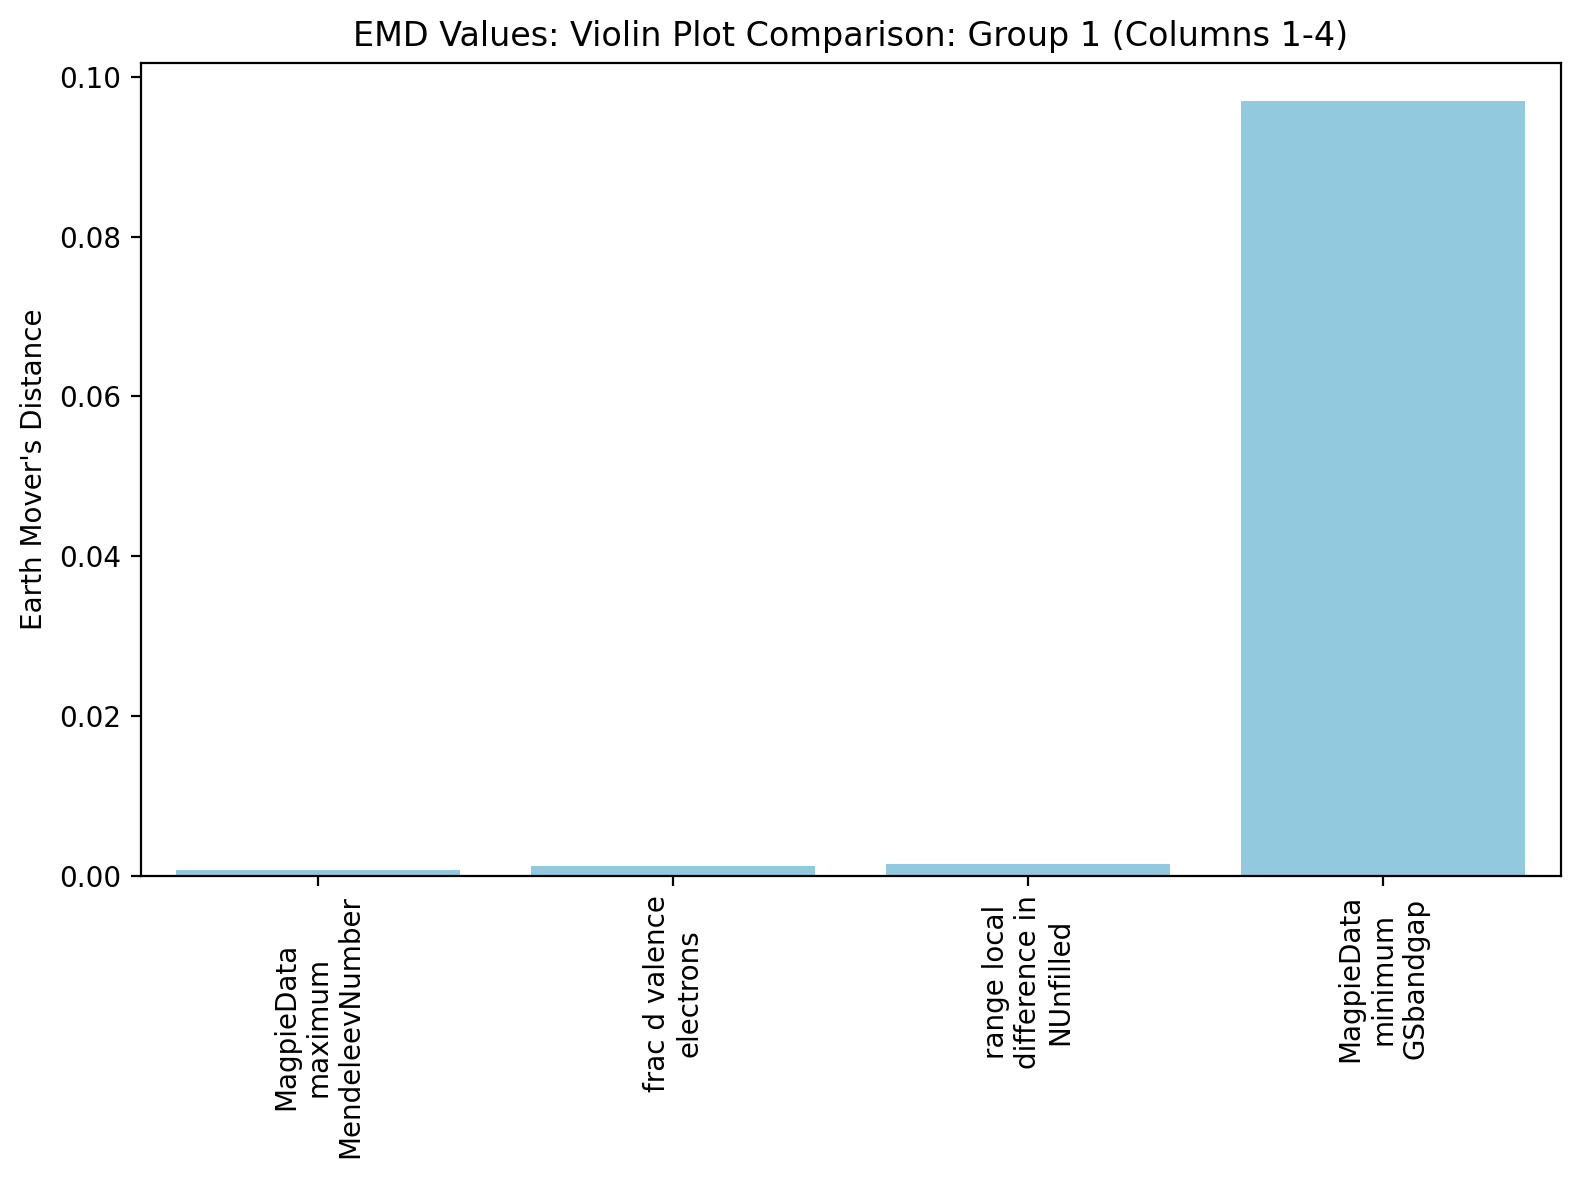

/var/folders/n6/hpx7mkvn27z0rq_zwzjbg8nm0000gn/T/ipykernel_12310/1138563575.py:190: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_all.set_xticklabels(wrapped_all_labels)


The feature(s) with the largest EMD of 0.0969 are:
 - MagpieData minimum GSbandgap


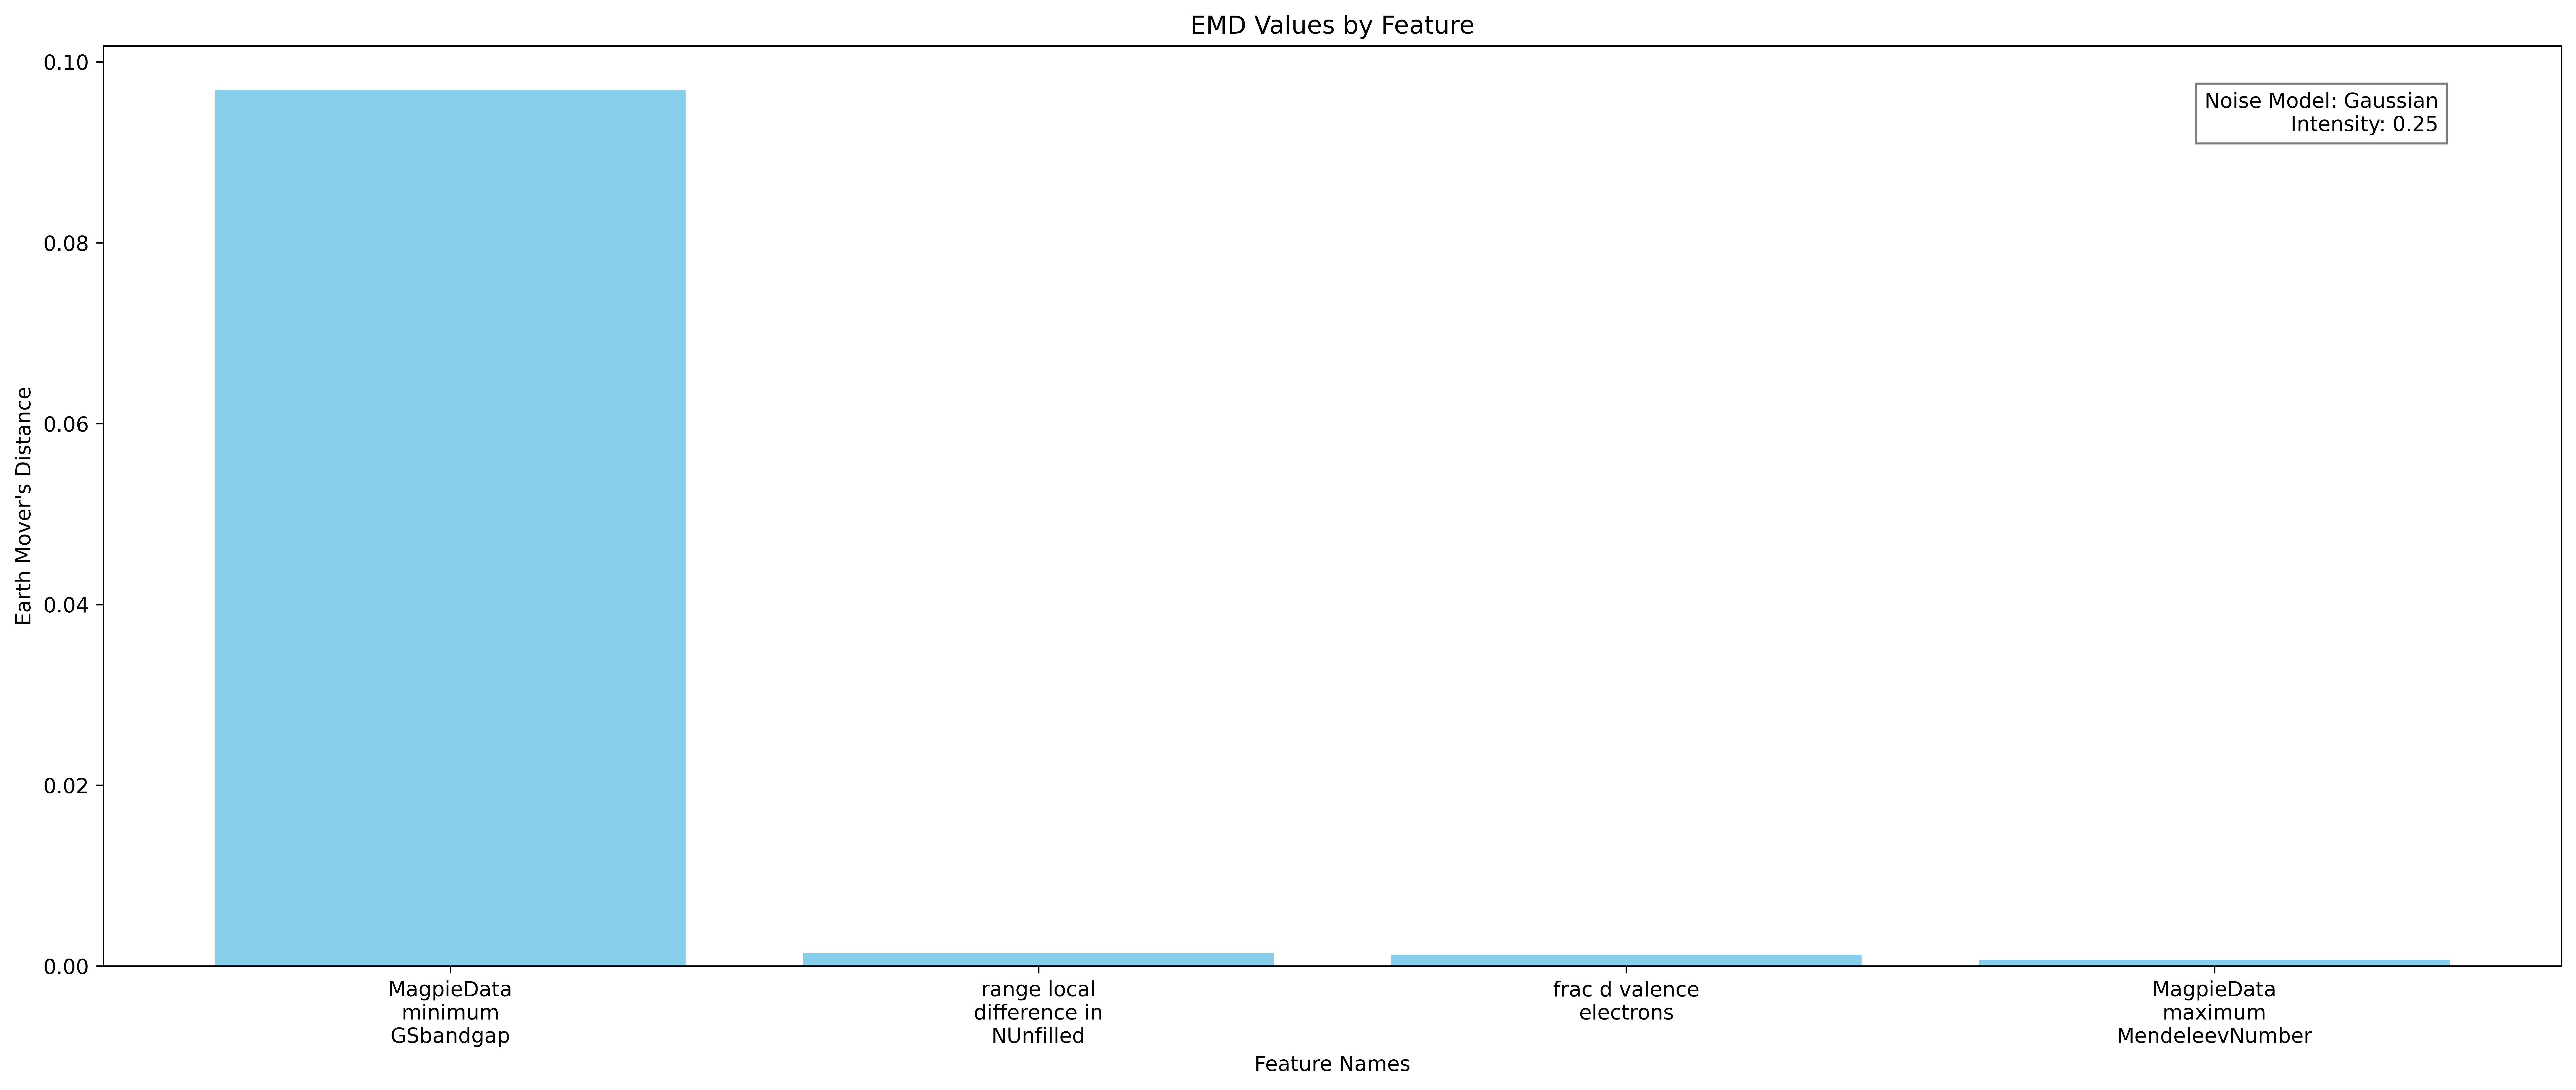

In [ ]:
# Existing variables and data
noisy_feature = 'MagpieData minimum GSbandgap'
delta_noise = results[noisy_feature]["y_test_diffs"]

# Convert delta_base and delta_noise into DataFrames
delta_base = pd.DataFrame(delta_base)
delta_noise = pd.DataFrame(delta_noise)

# Convert column names to strings for consistency
delta_base.columns = delta_base.columns.map(str)
delta_noise.columns = delta_noise.columns.map(str)

# Identify common columns between delta_base and delta_noise
common_columns = delta_base.columns.intersection(delta_noise.columns).tolist()

# === Feature Selection ===
# Specify the list of features you want to plot. For example:
selected_features = ['MagpieData minimum GSbandgap',
                     'MagpieData maximum MendeleevNumber',
                     'frac d valence electrons',
                     'range local difference in NUnfilled']
# If you want to plot all features, you can leave selected_features empty or comment out the next filtering block.
if selected_features:
    common_columns = [col for col in common_columns if col in selected_features]
# ==========================

# Sanitize the noisy_feature name for use in a filename
def sanitize_filename(name):
    return re.sub(r'[^A-Za-z0-9_\-]', '_', name)

sanitized_noisy_feature = sanitize_filename(noisy_feature)

# Adjust the number of columns per group if needed
columns_per_group = 8  # Adjust this number based on the total number of common columns

# Build groups using common columns
groups = [
    (
        common_columns[i:i+columns_per_group],
        f'Group {j} (Columns {i+1}-{i+len(common_columns[i:i+columns_per_group])})'
    )
    for j, i in enumerate(range(0, len(common_columns), columns_per_group), 1)
]

# Define compute_emd function
def compute_emd(delta_base, delta_noise, columns):
    emd_values = {}
    for feature in columns:
        # Extract the values for the current feature
        base_values = delta_base[feature].dropna()
        noise_values = delta_noise[feature].dropna()
        
        # Compute the Earth Mover's Distance
        emd = wasserstein_distance(base_values, noise_values)
        emd_values[feature] = emd
    return emd_values

# Modify the plot_violin_comparison function
def plot_violin_comparison(delta_base, delta_noise, columns, title, noise_model, intensity, filename, emd_bar_filename):
    num_columns = len(columns)
    plt.figure(figsize=(10, 8))  # Increased figure size

    # Combine the two datasets into one for violin plot
    combined_df = pd.concat([
        delta_base[columns].melt(var_name='Feature', value_name='Value').assign(Dataset='Delta Base'),
        delta_noise[columns].melt(var_name='Feature', value_name='Value').assign(Dataset='Delta Noise')
    ], ignore_index=True)

    # Create the violin plot with split violins
    sns.violinplot(
        x='Feature', y='Value', hue='Dataset', data=combined_df,
        inner='quartile', split=True, scale='count', linewidth=1, cut=0,
    )

    # Compute EMD for each feature
    emd_values = compute_emd(delta_base, delta_noise, columns)

    # Annotate EMD on the plot
    for idx, feature in enumerate(columns):
        emd = emd_values[feature]
        # Adjust max_value per feature to ensure the annotation is placed correctly
        max_value = combined_df[combined_df['Feature'] == feature]['Value'].max()
        plt.text(
            idx, max_value * 1.01, f"EMD={emd:.2f}",
            ha='center', va='bottom', fontsize=15, color='black'
        )

    # Additional plot formatting code
    plt.title(title)
    # plt.xlabel('Features')
    plt.ylabel('EMD Values')
    
    # Rotate x-axis tick labels and wrap long feature names into multiple lines
    # plt.xticks(rotation=90)
    ax = plt.gca()
    wrapped_labels = []
    for label in ax.get_xticklabels():
        # Wrap the label text with a width of 15 characters (adjust if necessary)
        wrapped = "\n".join(textwrap.wrap(label.get_text(), width=15))
        wrapped_labels.append(wrapped)
    ax.set_xticklabels(wrapped_labels)
    
    # Move legend to top left corner
    plt.legend(loc='upper left', fontsize=15)
    
    plt.tight_layout()

    # Save the violin plot to the specified filename
    plt.savefig(filename)
    plt.show()

    # Plot the EMD values as a separate bar plot
    plt.figure(figsize=(2 * max(num_columns, 1), 6))  # Increased figure size
    sns.barplot(x=list(emd_values.keys()), y=list(emd_values.values()), color='skyblue')
    plt.title(f'EMD Values: {title}')
    # plt.xlabel('Features')
    plt.ylabel("Earth Mover's Distance")
    plt.xticks(rotation=90)
    
    # Wrap x-axis tick labels for the bar plot as well
    ax_bar = plt.gca()
    wrapped_bar_labels = []
    for label in ax_bar.get_xticklabels():
        wrapped = "\n".join(textwrap.wrap(label.get_text(), width=15))
        wrapped_bar_labels.append(wrapped)
    ax_bar.set_xticklabels(wrapped_bar_labels)
    
    plt.tight_layout()
    plt.savefig(emd_bar_filename)
    plt.show()

# Call the function for each group with unique filenames that include the noisy feature
for idx, (columns, title) in enumerate(groups, 1):
    if not columns:
        print(f"Skipping group {idx} as it contains no common columns.")
        continue  # Skip empty groups
    filename = os.path.join(
        output_dir, 
        f'violin_comparison_{noise_model}_{intensity}_{sanitized_noisy_feature}_group{idx}.png'
    )
    emd_bar_filename = os.path.join(
        output_dir, 
        f'emd_values_{noise_model}_{intensity}_{sanitized_noisy_feature}_group{idx}.png'
    )
    plot_violin_comparison(
        delta_base, delta_noise, columns, f'Violin Plot Comparison: {title}',
        noise_model, intensity, filename, emd_bar_filename
    )

# Compute EMD values for all common features
all_columns = common_columns
emd_values_all = compute_emd(delta_base, delta_noise, all_columns)

# Find the maximum EMD value
max_emd_value = max(emd_values_all.values())

# Find all features that have the maximum EMD value
max_emd_features = [feature for feature, emd in emd_values_all.items() if emd == max_emd_value]

# Print out the feature(s) with the largest EMD and their value
print(f"The feature(s) with the largest EMD of {max_emd_value:.4f} are:")
for feature in max_emd_features:
    print(f" - {feature}")

# Sort EMD values in decreasing order
sorted_emd_values = dict(sorted(emd_values_all.items(), key=lambda item: item[1], reverse=True))

# Create a figure with larger size and high dpi for better quality
plt.figure(figsize=(18, 8), dpi=300)
plt.bar(sorted_emd_values.keys(), sorted_emd_values.values(), color='skyblue')
plt.xlabel('Feature Names')
plt.ylabel("Earth Mover's Distance")
plt.title('EMD Values by Feature')

# Wrap the x-axis tick labels for the bar plot
ax_all = plt.gca()
wrapped_all_labels = []
for label in ax_all.get_xticklabels():
    wrapped = "\n".join(textwrap.wrap(label.get_text(), width=15))
    wrapped_all_labels.append(wrapped)
ax_all.set_xticklabels(wrapped_all_labels)

# Add text for noise model and intensity
plt.text(
    0.95, 0.95, f'Noise Model: {noise_model}\nIntensity: {intensity}',
    horizontalalignment='right', verticalalignment='top',
    transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5)
)

plt.tight_layout(pad=3.0)  # Add padding for better layout

# Save the plot to the output directory
output_path = os.path.join(
    output_dir, 
    f'emd_values_{noise_model}_{intensity}_{sanitized_noisy_feature}_all_features.png'
)
plt.savefig(output_path)

# Display the plot
plt.show()


# Step 9: Define recoverable samples and calculate Recoverabilities

In [ ]:
# find the recovery error
delta_recovery = abs(df_test_pred - df_test)

# Create a boolean mask for nonzero entries in df_test
mask_nonzero = df_test != 0

# Use this mask to calculate MAPE only on rows/columns where df_test != 0
mape_recovery = (delta_recovery[mask_nonzero] / df_test[mask_nonzero]) * 100

delta_recovery.to_csv(os.path.join(output_dir, 'delta_recovery.csv'), index=False)
mape_recovery.to_csv(os.path.join(output_dir, 'mape_recovery.csv'))

# Flatten the DataFrame into a 1D array and remove any NaNs
all_values = mape_recovery.values.flatten()
all_values = all_values[~np.isnan(all_values)]

In [ ]:
def plot_violin_comparison(delta_base, delta_noise, columns, title, noise_model, intensity, filename):
    # Dynamically set figure size based on the number of columns
    num_columns = len(columns)
    plt.figure(figsize=(1.5 * num_columns, 8))

    # Combine the two datasets into one for violin plot
    combined_df = pd.concat([
        delta_base[columns].melt(var_name='Feature', value_name='Value').assign(Dataset='Delta Base'),
        delta_noise[columns].melt(var_name='Feature', value_name='Value').assign(Dataset='Delta Noise')
    ])

    sns.violinplot(x='Feature', y='Value', hue='Dataset', data=combined_df,
               split=True, inner='quartile', cut=0)

    # Plot the 95th percentiles for delta_base
    percentiles_95 = delta_base[columns].apply(lambda x: np.percentile(x, 95))
    for i, (feature, percentile_95) in enumerate(percentiles_95.items()):
        plt.plot([i - 0.2, i + 0.2], [percentile_95, percentile_95], color='black', linestyle='--',
                 label='95th Percentile' if i == 0 else "")  # Label only once

    plt.title(title)
    plt.xticks(rotation=90)
    # plt.ylim(0, 1)

    # First legend: Dataset and 95th Percentile, placed at the top-left
    handles, labels = plt.gca().get_legend_handles_labels()
    first_legend = plt.legend(handles=handles, labels=labels, loc='upper left')
    plt.gca().add_artist(first_legend)

    # Second legend: Noise model and intensity, placed at the top-right
    plt.legend([plt.Line2D([0], [0], color='white', linestyle='-', linewidth=0)],
               [f'Noise Model: {noise_model}\nIntensity: {intensity}'],
               loc='upper right', bbox_to_anchor=(1, 1), frameon=True,
               fancybox=True, edgecolor='black', facecolor='white')

    # Tighten layout before saving
    plt.tight_layout(pad=3.0)

    # Save the plot to the specified filename
    plt.savefig(filename)

    # Close the figure to free up memory
    plt.show()

def calculate_percentage_within_percentile(delta_base, delta_noise, columns):
    percentages_within_95 = {}
    percentage_outside_95 = {}
    # Dictionary to hold data frames for values outside the 95th percentile
    delta_noise_outside_95 = {}
    delta_recovery_outside_95 = {}
    mape_recovery_outside_95 = {}

    for column in columns:
        # Compute the 95th percentile from delta_base for the current column
        percentile_95 = np.percentile(delta_base[column], 95)
        
        # Boolean mask for values within the 95th percentile
        mask_within = delta_noise[column] <= percentile_95
        
        # Calculate counts and percentages
        count_within = np.sum(mask_within)
        total_count = len(delta_noise[column])
        percentage_within = (count_within / total_count) * 100
        percentages_within_95[column] = percentage_within
        
        percentage_outside = 100 - percentage_within
        percentage_outside_95[column] = percentage_outside
        
        # Save rows where the value in the column is outside the 95th percentile
        delta_noise_outside_95[column] = delta_noise[delta_noise[column] > percentile_95].copy()
        delta_recovery_outside_95[column] = delta_recovery[delta_noise[column] > percentile_95].copy()
        mape_recovery_outside_95[column] = mape_recovery[delta_noise[column] > percentile_95].copy()
    return percentages_within_95, percentage_outside_95, delta_noise_outside_95, delta_recovery_outside_95, mape_recovery_outside_95


# Recoverability calculations

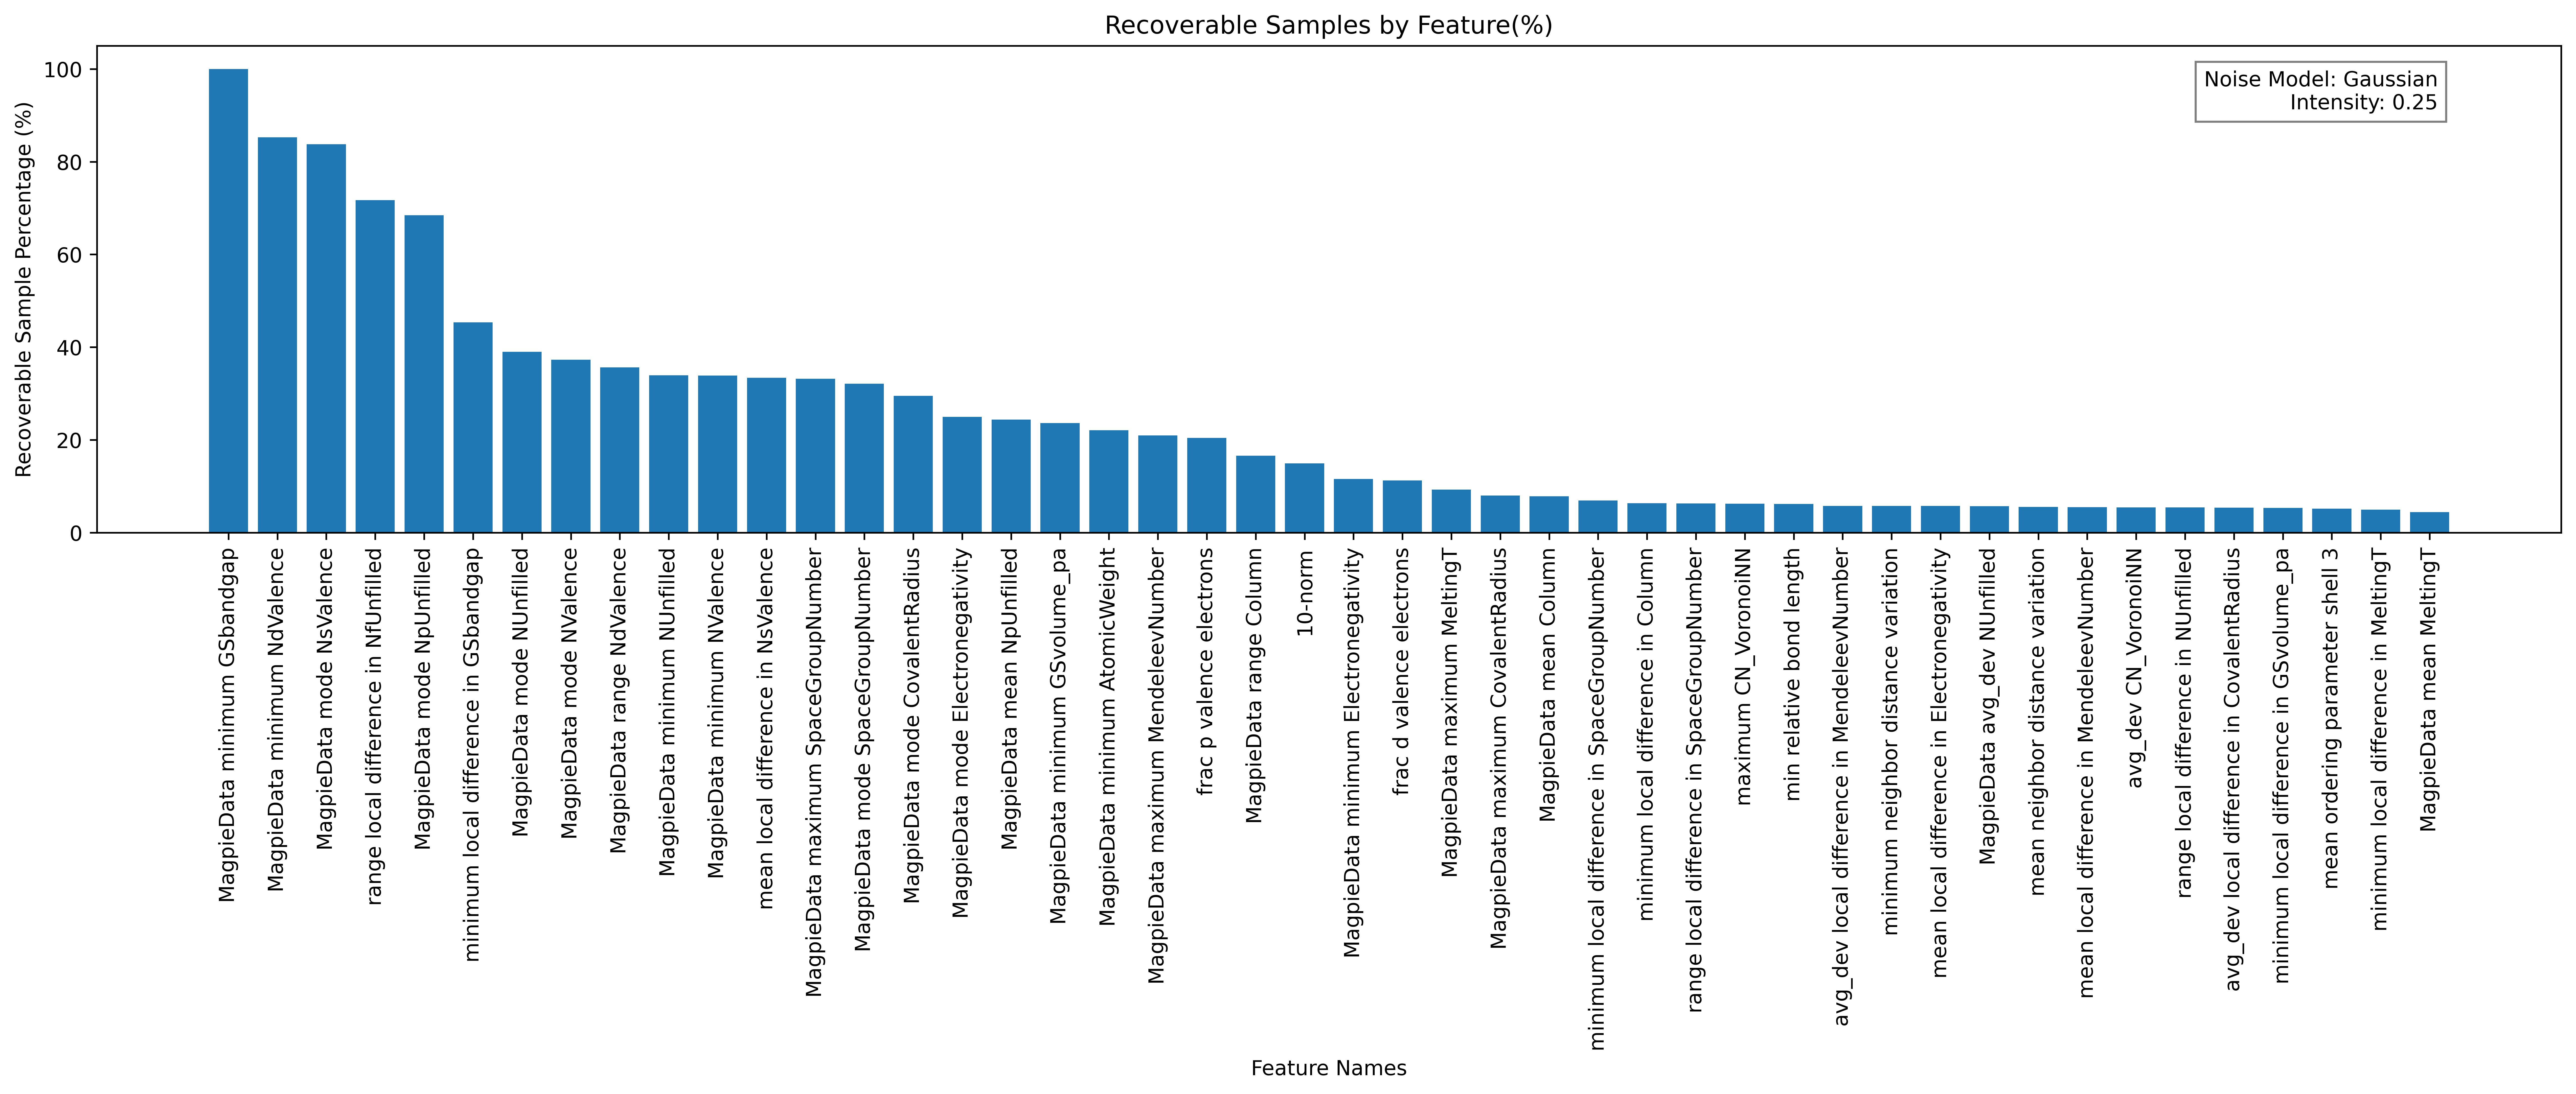

In [ ]:
# Call the function for each group with a unique filename
for idx, (columns, title) in enumerate(groups, 1):
    filename = os.path.join(output_dir, f'violin_comparison_{noise_model}_{intensity}_group{idx}.png')
    plot_violin_comparison(delta_base, delta_noise, columns, f'Violin Plot Comparison: {title}',
                           noise_model, intensity, filename)

# Create a copy of delta_noise where zeros are replaced with NaN
# so that only nonzero values are counted in the calculations.
delta_noise_nonzero = delta_noise.copy()
delta_noise_nonzero[delta_noise_nonzero == 0] = np.nan

# Calculate percentages within and outside 95th percentile using the filtered delta_noise_nonzero
all_columns = delta_base.columns
percentages_within_95, percentage_outside_95, delta_noise_outside_95, delta_recovery_outside_95, mape_recovery_outside_95 = calculate_percentage_within_percentile(delta_base, delta_noise, all_columns)
percentages_within_95 = pd.Series(percentages_within_95)
percentage_outside_95 = pd.Series(percentage_outside_95)
percentages_within_95.to_csv(os.path.join(output_dir, 'percentages_within_95.csv'))
percentage_outside_95.to_csv(os.path.join(output_dir, 'percentage_outside_95.csv'))

# Sort percentage_outside_95 in decreasing order
sorted_percentage_outside_95 = {k: v for k, v in sorted(percentage_outside_95.items(), key=lambda item: item[1], reverse=True)}

# Save the sorted percentages to a CSV file
pd.Series(sorted_percentage_outside_95).to_csv(os.path.join(output_dir, 'sorted_percentage_outside_95.csv'))

# Create a figure with a larger size and high dpi for better quality
plt.figure(figsize=(18, 8), dpi=300)
plt.bar(sorted_percentage_outside_95.keys(), sorted_percentage_outside_95.values())
plt.xticks(rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Recoverable Sample Percentage (%)')
plt.title('Recoverable Samples by Feature(%)')

# Add text for noise model and intensity
plt.text(0.95, 0.95, f'Noise Model: {noise_model}\nIntensity: {intensity}', 
         horizontalalignment='right', verticalalignment='top', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))

# Ensure layout is tight before saving
plt.tight_layout(pad=3.0)  # Add padding for better layout

# Save the plot to the output directory
output_path = os.path.join(output_dir, f'recoverable_samples_{noise_model}_{intensity}_{heaviness}.png')
plt.savefig(output_path)


# Step 10. Recoverable Samples corrections accurancy check

## Correction accurancy for individual features

In [ ]:
def plot_mape_distribution(data, feature_name, threshold=20, filename=None, save=False):
    """
    Histogram of MAPE distribution for a given feature, 
    with shaded threshold region.
    """
    percent_under = (data < threshold).mean() * 100

    fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

    # build a dynamic legend label
    legend_label = f"mean local difference in {feature_name}"

    counts, bins, patches = ax.hist(
        data,
        bins=50,
        range=(0, 100),
        edgecolor="black",
        color="blue",
        alpha=0.7,
        label=legend_label
    )

    ax.axvspan(0, threshold, facecolor="red", alpha=0.2)
    ax.axvline(
        threshold,
        color="red",
        linestyle="--",
        linewidth=1.0,
        label=f"{threshold}% MAPE Threshold"
    )

    ax.set_xlabel("Mean Absolute Percentage Error (MAPE) (%)", fontsize=8)
    ax.set_ylabel("Frequency", fontsize=8)
    ax.tick_params(axis="both", labelsize=8)

    ylim = ax.get_ylim()
    ax.text(
        threshold + 2,
        ylim[1] * 0.8,
        f"{percent_under:.1f}% of samples",
        fontsize=10,
        color="red"
    )

    ax.legend(fontsize=10, frameon=False, loc="upper right")

    # Panel label "(b)" — you can also make this dynamic if needed
    ax.text(
        -0.1,
        1.05,
        "(b)",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold"
    )

    fig.tight_layout()
    if save and filename:
        fig.savefig(
            filename,
            dpi=300,
            facecolor="white",
            bbox_inches="tight"
        )
    plt.close(fig)


# now loop over all features in df_test
save_folder = os.path.join(output_dir, "mape_distributions")
os.makedirs(save_folder, exist_ok=True)

for feature in df_test.columns:
    # get the array of MAPE for this feature
    data = mape_recovery_outside_95[feature][feature]
    
    # sanitize filename
    safe_name = feature.replace(" ", "_").replace("/", "_")
    fname = os.path.join(save_folder, f"mape_{safe_name}.png")
    
    plot_mape_distribution(
        data,
        feature_name=feature,
        threshold=20,
        filename=fname,
        save=True
    )

## Correction accurancy for all features

In [ ]:
def plot_mape_all_features(mape_dict, threshold=20, filename=None, save=False):
    """
    Aggregated histogram of MAPE across all features with styled threshold shading,
    following npj Computational Materials figure standards.
    """
    # Aggregate all feature series
    all_series = [df[feat].dropna() for feat, df in mape_dict.items()]
    data = pd.concat(all_series)

    # Compute percentage under threshold
    percent_under = (data < threshold).mean() * 100

    # Create figure (~6"x4" at 300 dpi)
    fig, ax = plt.subplots(figsize=(5, 4), dpi=300)

    # 1) Histogram with label
    ax.hist(
        data,
        bins=50,
        range=(0, 100),
        edgecolor="black",
        color="blue",
        alpha=0.7,
        label="All Features"
    )

    # 2) Shaded threshold region
    ax.axvspan(0, threshold, facecolor="red", alpha=0.2)

    # 3) Threshold line with label
    ax.axvline(
        threshold,
        color="red",
        linestyle="--",
        linewidth=1.0,
        label=f"{threshold}% MAPE Threshold"
    )

    # 4) Axis labels (8 pt bold)
    ax.set_xlabel("Mean Absolute Percentage Error (MAPE) (%)", fontsize=8)
    ax.set_ylabel("Frequency", fontsize=8)

    # 5) Tick label sizes
    ax.tick_params(axis="both", labelsize=8)

    # 6) Annotation text
    ylim = ax.get_ylim()
    ax.text(
        threshold + 2,
        ylim[1] * 0.8,
        f"{percent_under:.1f}% of samples",
        fontsize=10,
        color="red"
    )

    # 7) Legend (6 pt) inside top-right
    ax.legend(
        fontsize=10,
        frameon=False,
        loc="upper right"
    )

    # 8) Panel label "(d)" at top-left
    ax.text(
        -0.1, 1.05, "(a)",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold"
    )

    fig.tight_layout()
    if save and filename:
        fig.savefig(
            filename,
            dpi=300,
            facecolor="white",
            bbox_inches="tight"
        )
    else:
        plt.show()

# Example usage:
plot_mape_all_features(
    mape_recovery_outside_95,
    threshold=20,
    filename=os.path.join(output_dir, "mape_all_features.png"),
    save=True
)